# Bank Marketing : 정기 예금 가입 예측 모델기반 마케팅 전략 제안

[목차]

1. 개요
    - 배경
    - 분석 목적
    - 분석 목표
    - 데이터 설명
    - 라이브러리 호출

2. EDA
    - 기술통계분석 및 데이터 확인
    - 결측치, 중복값이상치 확인
    - 상관관계 분석
    - 카테고리별 세부 분석
    
3. Feature Engineering    
    - One-Hot Encoding
    - 파생변수 생성
    - Feature 선별
    
3. 예측 모델 개발
    - 랜덤포레스트
    - lightgbm
    - XGboost
    
5. 클러스터링 분석 및 전략 제안
    - K-means

6. 결론
    - 분석 과정 요약
    - 마케팅 전략 요약

---
---

## 개요

### 1) 배경
- 포르투갈 은행은 2008년부터 2010년까지 다양한 마케팅 캠페인을 통해 고객들에게 정기 예금 가입을 유도해왔다. 그러나 모든 고객이 캠페인에 긍정적으로 반응하는 것은 아니며, 무작위로 마케팅을 진행할 경우 불필요한 비용이 발생하고 마케팅 효율성이 저하될 수 있다. 따라서 데이터를 기반으로 정기 예금 가입 가능성이 높은 고객을 식별하고, 효과적인 마케팅 전략을 수립하는 것에 대한 중요성이 대두되었다.

### 2) 분석 목적
-  결정 트리 및 앙상블 기법을 활용하여 고객이 정기 예금에 가입할 가능성을 예측하는 분류 모델을 구축하여 마케팅 캠페인의 성공률을 높이고, 은행의 고객 확보 전략을 최적화하기 위함


### 3) 분석 목표
- 결정 트리 및 랜덤 포레스트, 그래디언트 부스팅 등 다양한 앙상블 모델을 활용하여 예측 성능을 비교하고 최적의 모델을 선택한다.

- 예측 모델 기반으로 중요한 변수 선별하여 해당 변수 기반 클러스터링으로 고객 세그먼트 맞춤별 마케팅 전략을 도출한다.

### 4) 데이터 설명
- 2008년부터 2010년까지의 은행 마케팅 캠페인 데이터


| 컬럼명           | 설명                 | 타입  |
|----------------|----------------|------|
| age           | 나이                 | 숫자  |
| job           | 직업                 | 범주형 |
| marital       | 결혼 여부             | 범주형 |
| education     | 교육 수준             | 범주형 |
| default       | 신용 불량 여부         | 범주형 |
| housing       | 주택 대출 여부         | 범주형 |
| loan          | 개인 대출 여부         | 범주형 |
| contact       | 연락 유형             | 범주형 |
| month         | 마지막 연락 월         | 범주형 |
| day_of_week   | 마지막 연락 요일       | 범주형 |
| duration      | 마지막 연락 지속 시간  | 숫자  |
| campaign      | 캠페인 동안 연락 횟수  | 숫자  |
| pdays        | 이전 캠페인 후 지난 일수 | 숫자  |
| previous      | 이전 캠페인 동안 연락 횟수 | 숫자  |
| poutcome      | 이전 캠페인의 결과      | 범주형 |
| emp.var.rate  | 고용 변동률           | 숫자  |
| cons.price.idx| 소비자 물가지수        | 숫자  |
| cons.conf.idx | 소비자 신뢰지수        | 숫자  |
| euribor3m     | 3개월 유리보 금리      | 숫자  |
| nr.employed   | 고용자 수             | 숫자  |
| y             | 정기 예금 가입 여부     | 이진  |

- 특이사항
  - pdays가 999이면, 이전에 연락한 적이 없음을 의미

### 5) 라이브러리 호출 및 df 생성

In [63]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ▶ 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# bank 데이터 셋 호출
bank_df = pd.read_csv('/content/drive/MyDrive/DA 프로젝트/data/bank-additional-full.csv',sep=";")
bank_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


---

## EDA

### 1) 데이터 확인 및 기술통계분석

In [5]:
# 데이터 크기 확인
bank_df.shape

(41188, 21)

In [6]:
len(bank_df[bank_df['pdays'] == 999])

39673

In [7]:
# 데이터 확인
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
# 기술통계확인
bank_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


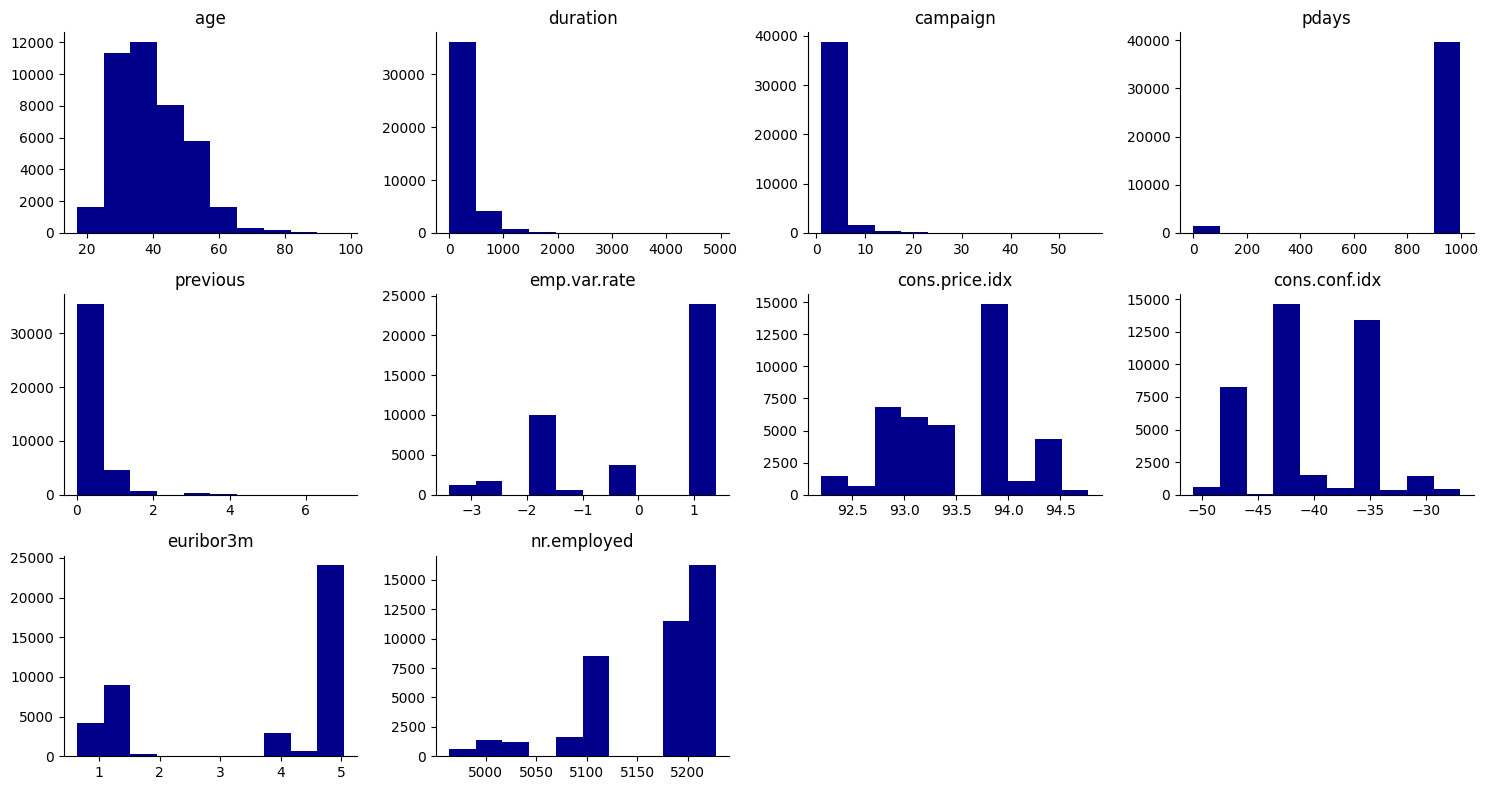

In [9]:
# 히스토그램 시각화
# 변수 선별
numeric_df = bank_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

### 2) 결측치, 중복값, 이상치 처리

In [10]:
# 결측치 확인 > 결측치 0개
bank_df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


- 중복값 제거

In [160]:
# 중복값 존재 확인
bank_df.duplicated().sum()

12

In [161]:
# 중복 데이터 제거
preprocessed_df = bank_df.drop_duplicates()
preprocessed_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


- 이상치 처리

In [162]:
# 수치형 변수 선택
numeric_cols = list(preprocessed_df.select_dtypes('number').columns)

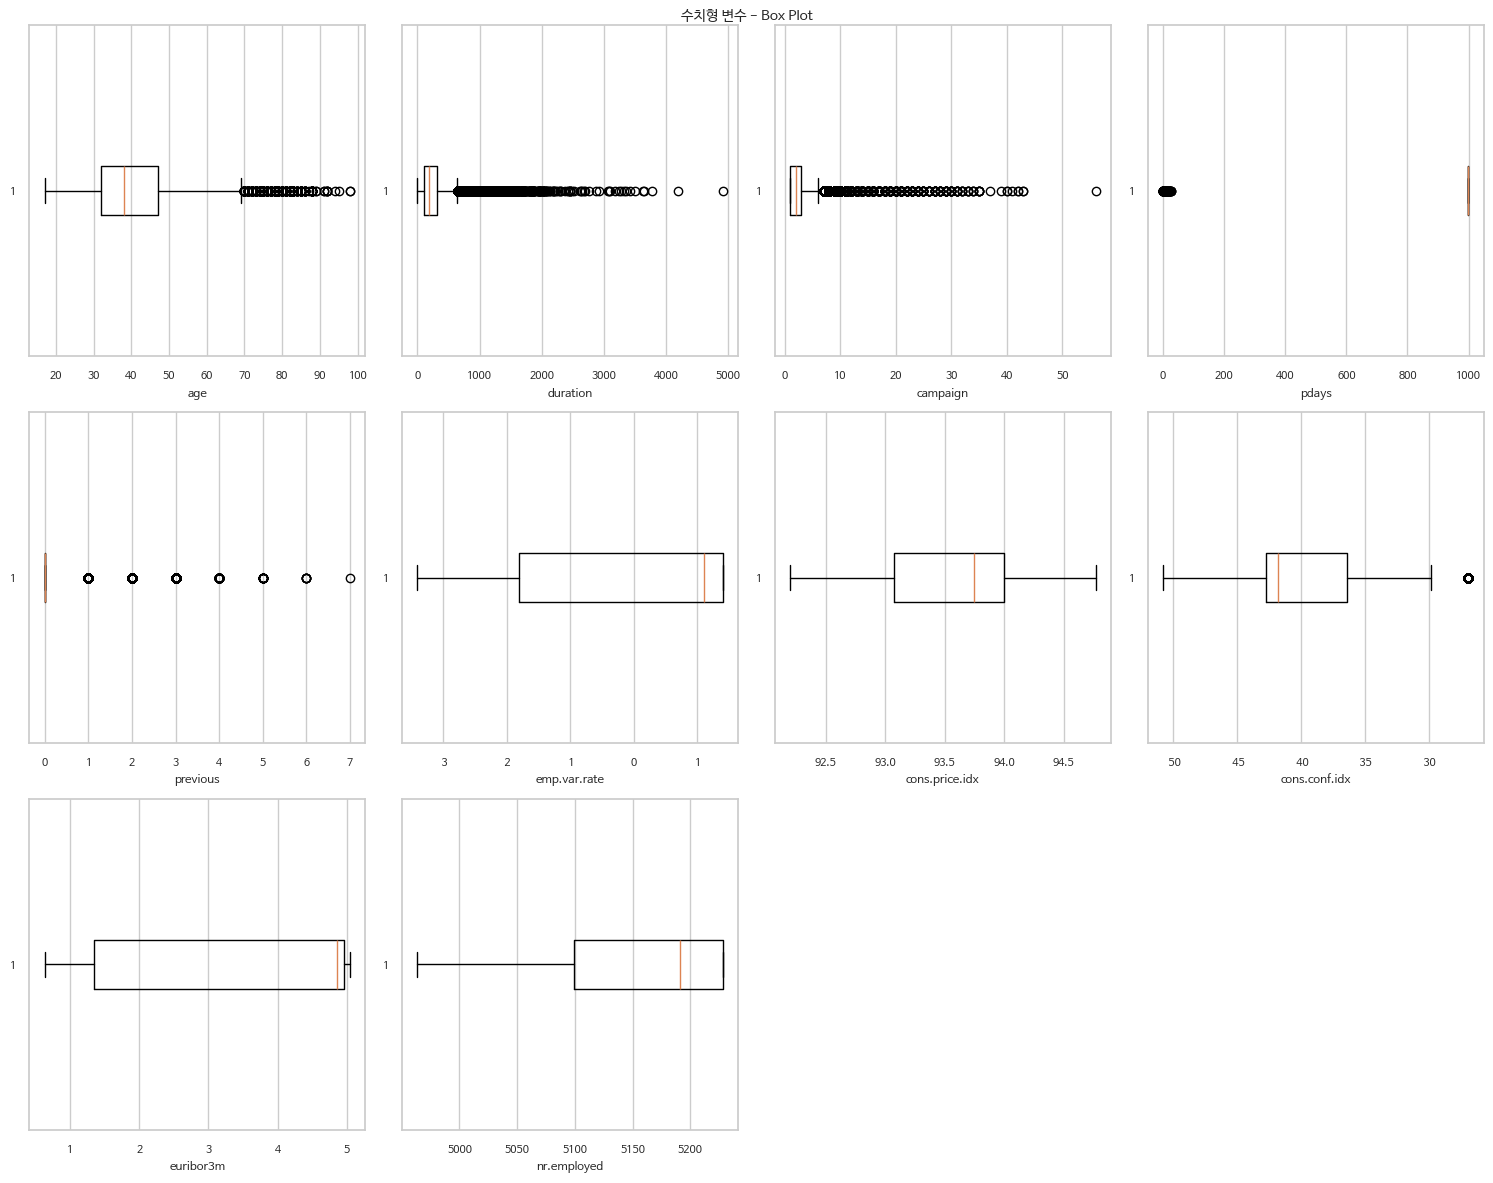

In [163]:
# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='NanumBarunGothic')

fig, axes = plt.subplots(3,4,figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(preprocessed_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

> 결론
- `age`, `duration`, `campaign`, `pdays`에서 많은 이상치 발견
- 이상치 발생한 컬럼의 이상치 개수 확인해본다.

- 사분위수 이상치 탐지

In [164]:
for col in numeric_cols:
  q1 = preprocessed_df[col].quantile(0.25)
  q3 = preprocessed_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(preprocessed_df[(preprocessed_df[col] < (q1 - (1.5*iqr)))|(preprocessed_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(preprocessed_df))*100,2)}%")

age - 이상치 개수: 468 / 비율: 1.14%
duration - 이상치 개수: 2963 / 비율: 7.2%
campaign - 이상치 개수: 2406 / 비율: 5.84%
pdays - 이상치 개수: 1515 / 비율: 3.68%
previous - 이상치 개수: 5625 / 비율: 13.66%
emp.var.rate - 이상치 개수: 0 / 비율: 0.0%
cons.price.idx - 이상치 개수: 0 / 비율: 0.0%
cons.conf.idx - 이상치 개수: 446 / 비율: 1.08%
euribor3m - 이상치 개수: 0 / 비율: 0.0%
nr.employed - 이상치 개수: 0 / 비율: 0.0%


- KNN 알고리즘으로 이상치 탐지 및 처리
  - 사분위수를 활용한 이상치 탐지 결과 이상치가 비교적 많이 탐지됨
  - 예측 모델 개발을 위해서는 데이터를 최대한 보존하는 것이 좋으므로 KNN 알고리즘을 통해 이상치를 처리하기로 한다.
  - ***최근접 이웃들의 평균으로 이상치를 대치한다.***

In [165]:
from sklearn.neighbors import NearestNeighbors

# 데이터 누수 방지를 위해 데이터프레임 복제
outlier_processed_df = preprocessed_df.copy()

# KNN 모델을 사용하여 이웃 계산
knn = NearestNeighbors(n_neighbors=5)  # n_neighbors 값을 직접 설정

# 데이터로 학습
knn.fit(outlier_processed_df[numeric_cols])

# 각 샘플에 대해 가장 가까운 이웃까지의 거리 계산
distances, indices = knn.kneighbors(outlier_processed_df[numeric_cols])

# distance_threshold 값을 결정하는 방법 (상위 90% 거리값 기준)
distance_threshold = np.percentile(distances[:, -1], 90)

# 이상치 판별
outliers = distances[:, -1] > distance_threshold

# 이상치 대치 (예: 가까운 이웃의 평균값으로 대체)
for i in range(outlier_processed_df[numeric_cols].shape[0]):
    if outliers[i]:
        # 이상치인 경우, 해당 샘플의 이웃들의 평균값으로 대체
        outlier_processed_df[numeric_cols].iloc[i] = np.mean(outlier_processed_df[numeric_cols].iloc[indices[i]], axis=0)

# 결과 출력
print(f"감지된 이상치 개수: {sum(outliers)}")

감지된 이상치 개수: 4118


In [166]:
outlier_processed_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41176.0,NaN,NaN,NaN,40.0238,10.42068,17.0,32.0,38.0,47.0,98.0
job,41176,12,admin.,10419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41176,4,married,24921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41176,8,university.degree,12164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41176,3,no,32577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41176,3,yes,21571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41176,3,no,33938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41176,2,cellular,26135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41176,10,may,13767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41176,5,thu,8618,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3) 상관관계 분석

- pdays가 999인 경우는 한번도 연락하지 않은 경우
  - 이 값은 해당 변수에서 연락하지 않은 경우를 표현하기에 충분히 크다고 판단되므로 별다른 처리없이 우선 진행

#### ㄴ 수치형 변수들간의 상관관계 시각화

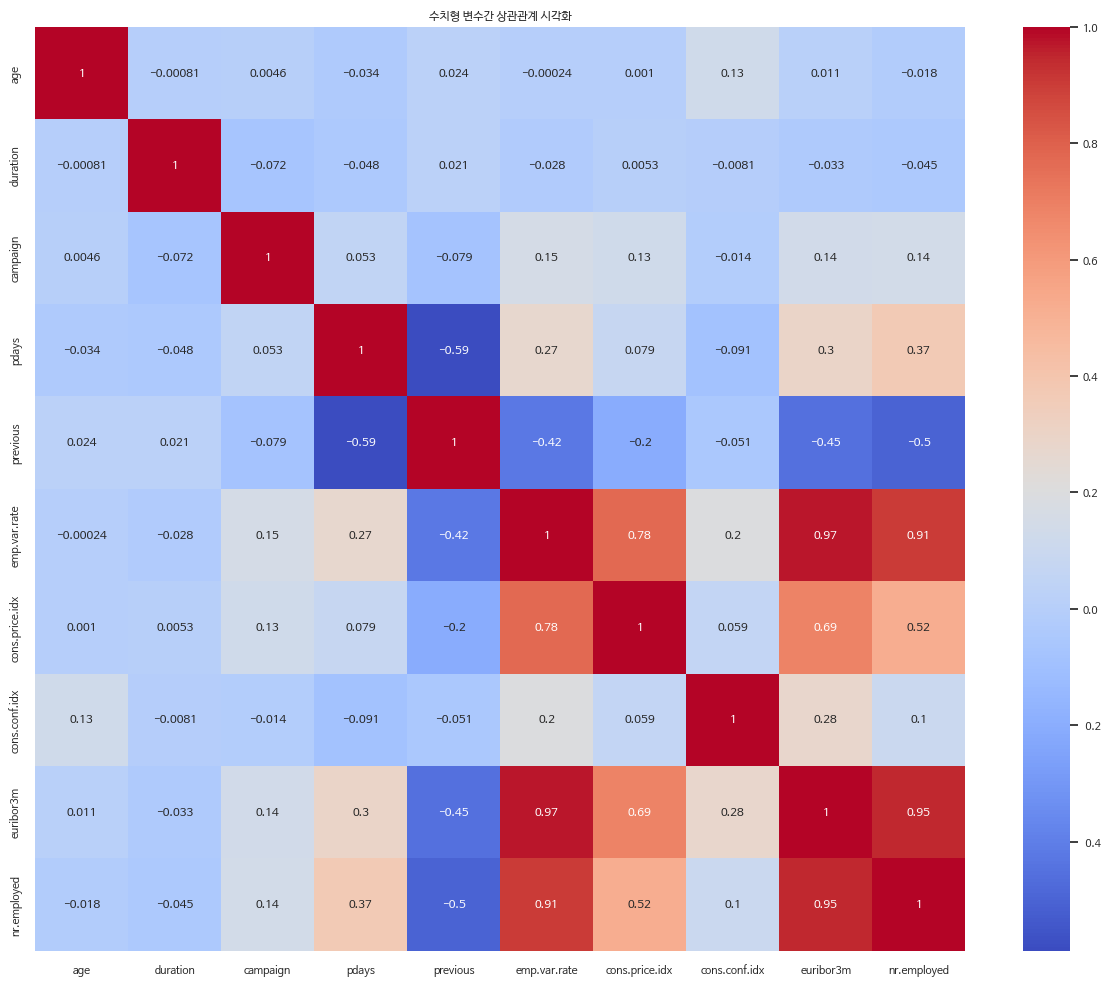

In [18]:
# 수치형 변수 df 선언
corr_df = outlier_processed_df.select_dtypes('number').corr()

# 수치형 변수간 상관관계 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(15,12)}, font_scale=0.7, font='NanumBarunGothic')
sns.heatmap(data=corr_df, annot=True, cmap='coolwarm')
plt.title('수치형 변수간 상관관계 시각화')
plt.show()

> 결론
- 독립변수 중 수치형 변수간 높은 상관관계 존재
- 아래 데이터 프레임 참고

In [19]:
# 상관관계 0.3 넘는 변수들
corr_df[corr_df > 0.3]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.372659
previous,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
emp.var.rate,NaN,NaN,NaN,NaN,NaN,1.000000,0.775293,NaN,0.972244,0.906949
cons.price.idx,NaN,NaN,NaN,NaN,NaN,0.775293,1.000000,NaN,0.688180,0.521945
cons.conf.idx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
euribor3m,NaN,NaN,NaN,NaN,NaN,0.972244,0.688180,NaN,1.000000,0.945146
nr.employed,NaN,NaN,NaN,0.372659,NaN,0.906949,0.521945,NaN,0.945146,1.000000


#### ㄴ 종속변수(y)와 상관관계 시각화

**1. 연속형 변수**

In [20]:
# 종속변수 원핫인코딩
encoded_df = pd.get_dummies(outlier_processed_df, columns=['y'], drop_first=True, dtype=int) # 다중공선성 문제를 피하기 위해 첫번째 열을 삭제
encoded_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_yes
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [159]:
# 원핫인코딩 확인
encoded_df['y_yes'].unique()

array([0, 1])

- 종속변수와의 상관관계 df 생성
  - 종속변수가 이진수로 표현된 범주형 변수이므로 `포인트-바이세리얼 상관계수` 사용

In [22]:
# 포인트-바이세리얼 상관계수 산출을 위한 라이브러리 호출
from scipy.stats import pointbiserialr
corr_dict = {}

# 포인트-바이세리얼 상관계수 계산
for col in encoded_df.select_dtypes('number').columns:
    corr, p_value = pointbiserialr(encoded_df['y_yes'], encoded_df[col])
    corr_dict[col] = corr


corr_y_df = pd.DataFrame(corr_dict, index=['corr']).T
corr_y_df

,corr
age,0.030381
duration,0.405297
campaign,-0.066361
pdays,-0.324948
previous,0.230202
emp.var.rate,-0.298289
cons.price.idx,-0.136134
cons.conf.idx,0.054802
euribor3m,-0.307740
nr.employed,-0.354669


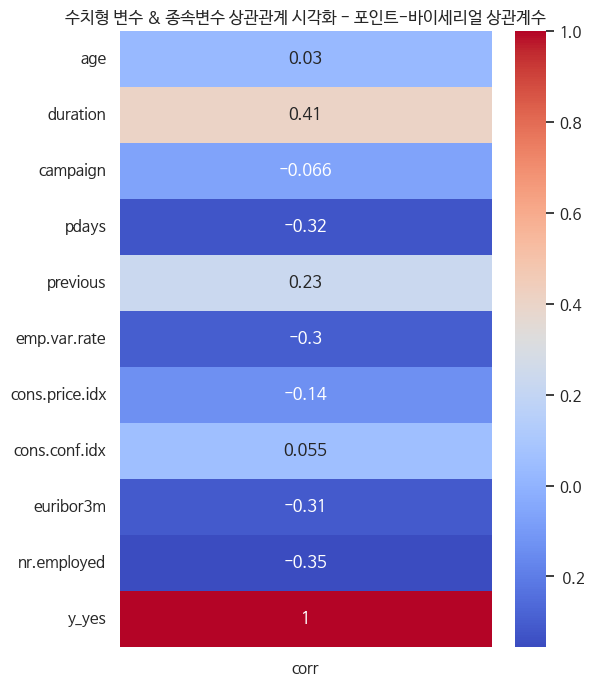

In [23]:
# 수치형 변수간 상관관계 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,8)}, font_scale=1, font='NanumBarunGothic')
sns.heatmap(data=corr_y_df , annot=True, cmap='coolwarm')
plt.title('수치형 변수 & 종속변수 상관관계 시각화 - 포인트-바이세리얼 상관계수')
plt.show()

> 결론
- 절댓값이 0.3이 넘는 상관관계
  - 양의 상관관계(+) : `duration`, `previous`
  - 음의 상관관계(-) : `pdays`, `emp.var.rate`, `euribor3m`, `nr.employed`

**2. 범주형 변수**

In [24]:
from scipy.stats import chi2_contingency
# 범주형 변수 리스트
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                    'month', 'day_of_week', 'poutcome']

# 카이제곱 검정 실행 및 결과 저장
chi2_results = {}
p_values = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(encoded_df[col], encoded_df['y_yes'])  # 교차표 생성
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = round(chi2,2)
    p_values[col] = p

# 카이제곱 통계량 및 p-value 따로따로 df 변환
chi2_df = pd.DataFrame(chi2_results, index=['Chi-Square']).T
chi2_pvalue_df = pd.DataFrame(p_values, index=['p-value']).T

# 각 변수별 카이제곱 통계량 및 p-value 확인
chi2_df.join(chi2_pvalue_df, how='inner')

,Chi-Square,p-value
job,961.74,3.268412e-199
marital,122.96,1.778423e-26
education,192.85,3.746768e-38
default,406.56,5.217541e-89
housing,5.74,5.663793e-02
loan,1.10,5.771532e-01
contact,862.08,1.718741e-189
month,3103.03,0.000000e+00
day_of_week,26.05,3.085755e-05
poutcome,4230.14,0.000000e+00


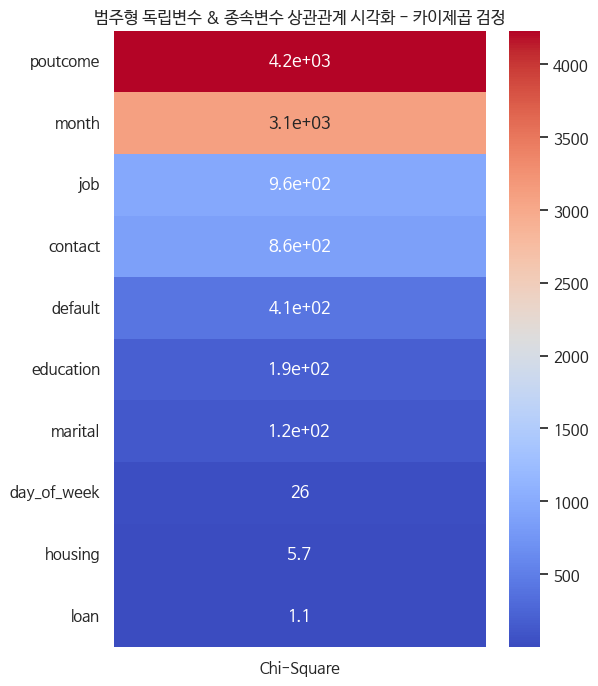

In [25]:
# 수치형 변수간 상관관계 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,8)}, font_scale=1, font='NanumBarunGothic')
sns.heatmap(data=chi2_df.sort_values(by='Chi-Square',ascending=False) , annot=True, cmap='coolwarm')
plt.title('범주형 독립변수 & 종속변수 상관관계 시각화 - 카이제곱 검정')
plt.show()

> 결론\
p-value가 0.05보다 작은 변수에 한해서 해석
- 가장 영향력이 큰 범주형 독립변수 - `poutcome`
- 가장 영향력이 작은 범주형 독립변수 - `day_of_week`
- 영향력 큰 순서대로 시각화(red $→$ blue)
- p-value가 0.05보다 큰 변수 - `housing`, `loan`

### 4) 카테고리별 세부 분석

각 컬럼을 회원정보, 마케팅 캠페인 데이터, 경제 지표의 3가지 카테고리로 나누어 세부적인 분석을 진행한다. 본 프로젝트의 최종 목적은 정기 에금 가입 예측 모델 개발이므로, 각 변수별로 정기 에금 가입에 미치는 영향을 파악하는 것을 중점으로 진행한다.

| 카테고리            | 변수                                                   |
|---------------------|--------------------------------------------------------|
| 회원 정보           | `age`, `job`, `marital`, `education`, `default`, `housing`, `loan`  |
| 마케팅 캠페인 데이터 | `month`, `day_of_week`, `duration`, `campaign`, `pdays`, `previous`, `poutcome` |
| 경제 지표            | `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`	, `nr.employed` |

#### ㄴ 회원정보

##### **[데이터 분포 확인]**

수치형 변수는 이전 단게에서 분포를 확인했으므로 범주형 이번 단계에서는 변수의 분포를 확인한다.



- 회원정보 범주형 변수 분포 시각화
  - 항목수가 많은 변수는 countplot으로 시각화
  - 항목수가 적은 변수는 pie차트로 시각화

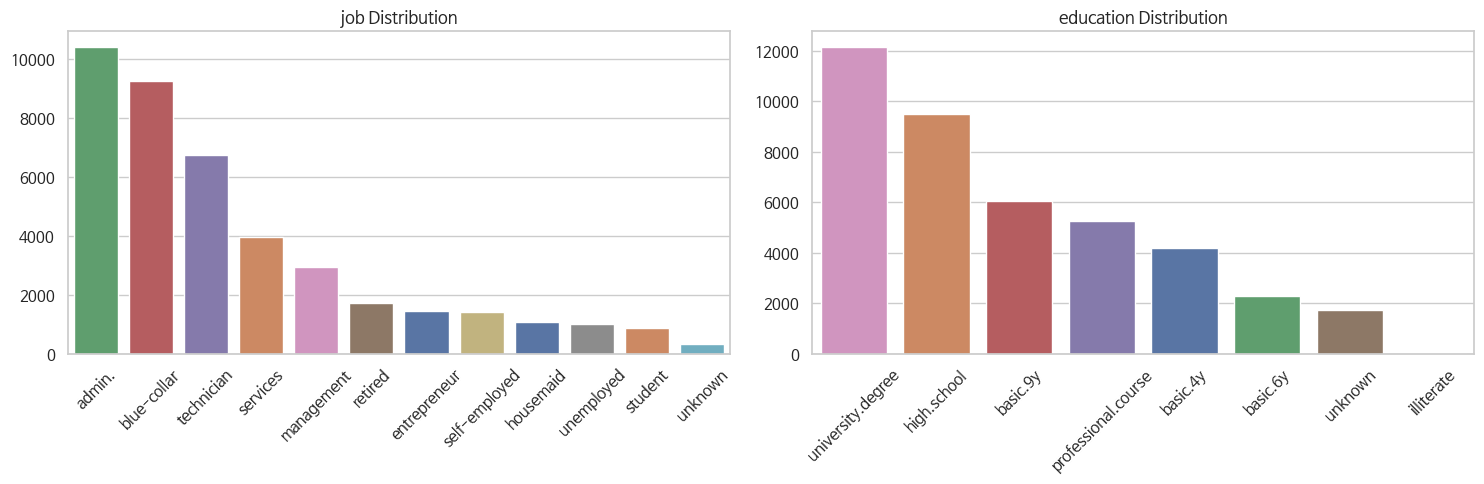

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 범주형 변수 리스트
categorical_cols = ['job', 'education']

# 서브플롯 크기 설정 (변수 개수에 맞게 행과 열 결정)
n_cols = 2  # 한 줄에 2개의 그래프
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)  # 필요한 행 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))

# 서브플롯을 평탄화
axes = axes.flatten()

# 각 변수에 대해 countplot 그리기
for i, col in enumerate(categorical_cols):
    order = outlier_processed_df[col].value_counts().index
    sns.countplot(x=col, data=outlier_processed_df, ax=axes[i], palette='deep',  hue=col, order=order)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

    if col == 'job' or col == 'education':
      axes[i].tick_params(axis='x', rotation=45)
    else: pass

# 여백 조정
plt.tight_layout()
plt.show()

In [27]:
# 파이차트 시각화 = marital', 'default', 'housing', 'loan'
import plotly.express as px

# 파이차트 그리기
pie_cols = ['marital', 'default', 'housing', 'loan']

for col in pie_cols:
    # 각 컬럼의 분포 계산
    category_counts = outlier_processed_df[col].value_counts().reset_index()
    category_counts.columns = ['category', 'values']

    # 파이차트 그리기
    fig = px.pie(category_counts, names='category', values='values', title=f'{col} Distribution')

    # 레이아웃 설정
    fig.update_layout(
        width=800,
        height=800,
    )

    # 차트 표시
    fig.show()


> 결론
- 'job', 'education', 'marital', 'default', 'loan'는 범주별 분포 차이가 뚜렷하게 존재한다.
- 'housing' 은 unknown 값을 제외하면 비교적 범주별 비율 차이가 적은 편이다.

##### **[회귀 분석]**
- 변수 영향력 파악을 위해 정기예금여부(y)를 종속변수로 설정하여 회귀분석을 진행해본다.


In [28]:
# VIF 계수 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립변수(X)와 종속변수(y) 설정
X = outlier_processed_df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
y = outlier_processed_df['y']

# 범주형 변수 원-핫 인코딩
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'], drop_first=True, dtype=int)
y = pd.get_dummies(y, columns=['y'], drop_first=True, dtype=int)

# 수치형 변수인 age 표준화
scaler = StandardScaler()
X['age'] = scaler.fit_transform(X[['age']])

# VIF 계수확인
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                          Feature       VIF
0                             age  1.606184
1                 job_blue-collar  2.337657
2                job_entrepreneur  1.128611
3                   job_housemaid  1.101793
4                  job_management  1.293349
5                     job_retired  1.427938
6               job_self-employed  1.129524
7                    job_services  1.474681
8                     job_student  1.162827
9                  job_technician  1.961504
10                 job_unemployed  1.089779
11                    job_unknown  1.071114
12                marital_married  4.862076
13                 marital_single  3.141457
14                marital_unknown  1.017139
15             education_basic.6y  1.369114
16             education_basic.9y  1.944978
17          education_high.school  2.430648
18           education_illiterate  1.003149
19  education_professional.course  2.176566
20    education_university.degree  2.910162
21              education_unknow

- VIF가 무한대(inf)인 변수 존재
  - 해당 변수가 완전히 다른 변수들의 선형 조합이라는 뜻, 해당 변수가 다른 변수들의 조합으로 정확하게 표현될 수 있기 때문에, 다중공선성이 극도로 높은 상태이므로 해당 변수는 제거한다.

In [29]:
# VIF가 무한대인 변수 제거
X = X.drop(columns=['housing_unknown', 'loan_unknown'])

In [30]:
# 회귀분석 진행
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 분석 수행
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 분석 결과 출력
print(result.summary())

         Current function value: 0.335774
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    yes   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41149
Method:                           MLE   Df Model:                           26
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.04622
Time:                        00:05:13   Log-Likelihood:                -13826.
converged:                      False   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                1.804e-266
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.1404      0.088    -24.325      0.000      -2.313      -1.968
age     

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



1차 결과 요약

- 주요 해석 (유의한 변수만 정리)

| 변수                       | 회귀 계수 (coef) | p-value   | 간단한 해석                                      |
|--------------------------|-----------------|-----------|--------------------------------------------------|
| age                      | 0.1490          | 0.000     | 나이가 1 증가할 때 정기 예금 가입 확률이 증가          |
| job_blue-collar          | -0.3792         | 0.000     | 블루칼라 직업일 경우 예금 가입 확률 감소              |
| job_entrepreneur         | -0.3775         | 0.000     | 기업가 직업일 경우 예금 가입 확률 감소               |
| job_management           | -0.1845         | 0.006     | 관리직일 경우 예금 가입 확률 감소                   |
| job_retired              | 0.7176          | 0.000     | 은퇴한 경우 예금 가입 확률 증가                      |
| job_self-employed        | -0.1922         | 0.038     | 자영업자는 예금 가입 확률이 감소                      |
| job_services             | -0.3037         | 0.000     | 서비스업 직군일 경우 예금 가입 확률 감소               |
| job_student              | 1.1802          | 0.000     | 학생일 경우 예금 가입 확률 증가                      |
| job_technician           | -0.1647         | 0.003     | 기술직일 경우 예금 가입 확률 감소                   |
| job_unemployed           | 0.2623          | 0.007     | 실업 상태일 경우 예금 가입 확률 증가                  |
| marital_married          | 0.1416          | 0.009     | 결혼한 경우 예금 가입 확률 증가                      |
| marital_single           | 0.4234          | 0.000     | 미혼인 경우 예금 가입 확률 증가                      |
| education_basic.9y       | -0.1544         | 0.039     | 9년 이하 교육 수준일 경우 예금 가입 확률 감소         |
| education_university.degree | 0.1773       | 0.013     | 대학 이상의 교육 수준일 경우 예금 가입 확률 증가      |
| education_unknown        | 0.2313          | 0.012     | 교육 수준 미제공일 경우 예금 가입 확률 증가            |
| default_unknown          | -0.9431         | 0.000     | 신용불량 미제공일 경우 예금 가입 확률 감소             |

<br>

- P-value > 0.05 (유의미하지 않은 변수)

| 변수                       | 회귀 계수 (coef) | p-value   | 간단한 해석                                      |
|--------------------------|-----------------|-----------|--------------------------------------------------|
| job_housemaid            | -0.1271         | 0.258     | 가사직일 경우 예금 가입 확률에 미미한 영향             |
| education_basic.6y       | 0.0065          | 0.946     | 교육 수준이 기본 6년인 경우 예금 가입 확률에 미미한 영향 |
| education_high.school    | -0.0425         | 0.554     | 고등학교 수준인 경우 예금 가입 확률에 미미한 영향     |
| education_illiterate     | 1.0189          | 0.081     | 문맹인 경우 예금 가입 확률이 증가하지만 유의미하지 않음 |
| education_professional.course | 0.0459     | 0.562     | 전문과정 교육 수준이 예금 가입 확률에 미미한 영향     |
| default_yes              | -15.5401        | 0.997     | 신용불량자가 예금 가입 확률에 미치는 영향이 매우 큼, 그러나 매우 큰 회귀 계수로 사실상 유의미하지 않음 |
| housing_yes              | 0.0571          | 0.074     | 주택 보유 여부가 예금 가입 확률에 미미한 영향           |
| loan_yes                 | -0.0565         | 0.208     | 대출 여부가 예금 가입 확률에 미미한 영향               |

> p-value가 > 0.05인 변수들을 위 표에 정리한대로 처리한 후 다시 회귀분석 실시

In [31]:
# 기존 데이터프레임에서 불필요한 변수 제거
drop_columns = [
    "job_housemaid", "job_unknown", "marital_unknown", "default_yes"
]

# 교육 변수 통합
X["education_basic"] = X[["education_basic.6y", "education_high.school"]].sum(axis=1)
X["education_higher"] = X[["education_professional.course", "education_university.degree"]].sum(axis=1)

# 기존 교육 관련 컬럼 삭제
drop_columns += ["education_basic.6y", "education_high.school",
                 "education_professional.course", "education_university.degree"]

# 상호작용 변수 추가 (housing과 loan)
X["housing_loan"] = X["housing_yes"] * X["loan_yes"]

# 기존 housing, loan 변수 제거
drop_columns += ["housing_yes", "loan_yes"]

# 새로운 X 변수 설정, y는 그대로
X = X.drop(columns=drop_columns)

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 실행
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.335938
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    yes   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41156
Method:                           MLE   Df Model:                           19
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.04576
Time:                        00:05:13   Log-Likelihood:                -13833.
converged:                       True   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                7.027e-270
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1196      0.081    -26.222      0.000      -2.278      -1.961

> 결과 해석

- 유의미한 변수 (p-value < 0.05)

| 변수                     | 회귀 계수 (coef) | p-value   | 간단한 해석                                      |
|--------------------------|-----------------|-----------|--------------------------------------------------|
| age                      | 0.1463          | 0.000     | 나이가 1 증가할 때 정기 예금 가입 확률이 증가          |
| job_blue-collar          | -0.3781         | 0.000     | 블루칼라 직업일 경우 예금 가입 확률 감소              |
| job_entrepreneur         | -0.3712         | 0.000     | 기업가 직업일 경우 예금 가입 확률 감소               |
| job_management           | -0.1659         | 0.012     | 관리직일 경우 예금 가입 확률 감소                   |
| job_retired              | 0.7192          | 0.000     | 은퇴한 경우 예금 가입 확률 증가                      |
| job_self-employed        | -0.1857         | 0.043     | 자영업자는 예금 가입 확률이 감소                      |
| job_services             | -0.3135         | 0.000     | 서비스업 직군일 경우 예금 가입 확률 감소               |
| job_student              | 1.1693          | 0.000     | 학생일 경우 예금 가입 확률 증가                      |
| job_technician           | -0.2085         | 0.000     | 기술직일 경우 예금 가입 확률 감소                   |
| job_unemployed           | 0.2582          | 0.007     | 실업 상태일 경우 예금 가입 확률 증가                  |
| marital_married          | 0.1328          | 0.013     | 결혼한 경우 예금 가입 확률 증가                      |
| marital_single           | 0.4215          | 0.000     | 미혼인 경우 예금 가입 확률 증가                      |
| education_unknown        | 0.2478          | 0.007     | 교육 수준 미제공일 경우 예금 가입 확률 증가            |
| default_unknown          | -0.9436         | 0.000     | 신용불량 미제공일 경우 예금 가입 확률 감소             |
| education_higher         | 0.1611          | 0.014     | 고등교육 이상의 교육 수준일 경우 예금 가입 확률 증가    |

<br>

- 유의미하지 않은 변수 (p-value > 0.05)

| 변수                     | 회귀 계수 (coef) | p-value   | 간단한 해석                                      |
|--------------------------|-----------------|-----------|--------------------------------------------------|
| education_basic.9y        | -0.1412         | 0.056     | 9년 이하 교육 수준일 경우 예금 가입 확률에 미미한 영향         |
| education_illiterate      | 1.0284          | 0.078     | 문맹인 경우 예금 가입 확률이 증가하지만 유의미하지 않음        |
| education_basic           | -0.0215         | 0.746     | 교육 수준이 기본인 경우 예금 가입 확률에 미미한 영향            |
| housing_loan              | -0.0491         | 0.380     | 주택 대출 여부가 예금 가입 확률에 미미한 영향                  |

<br>


> 결론
- 회귀 분석 결과로 유의미한 변수들(연령, 직업, 결혼 여부 등)이 종속변수에 강한 영향
- 모델 개발시 교육(education)은 추가 Engineering 필요
- 유의미하지 않은 변수들은 모델에서 제거(housing, loan)

#### ㄴ 마케팅 캠페인 데이터

- 마케팅 캠페인 데이터 - `contact`, `month`, `day_of_week`, `duration`, `campaign`, `pdays`, `previous`, `poutcome`



##### **[데이터 분포 확인]**

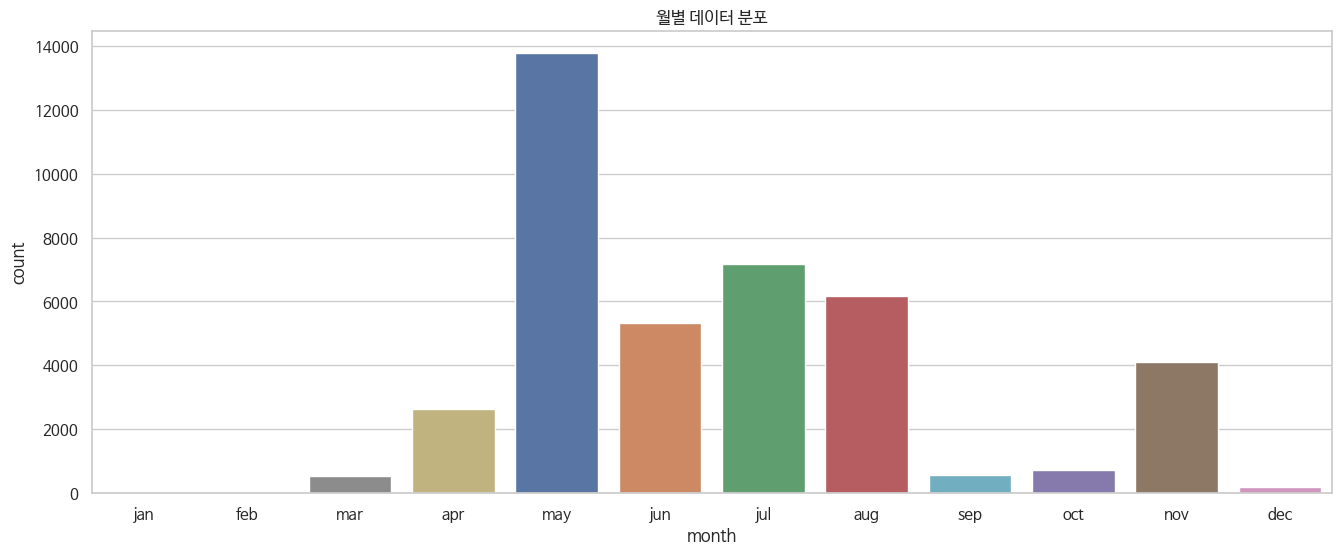

In [32]:
# 월별 데이터 분포 시각화
plt.figure(figsize=(16,6))
order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sns.countplot(x='month', data=outlier_processed_df, palette='deep',order=order,  hue='month')
plt.title('월별 데이터 분포')
plt.show()

In [33]:
# 파이차트 그리기
category_counts = outlier_processed_df[col].value_counts().reset_index()
category_counts.columns = ['category', 'values']

fig = px.pie(category_counts, names='category', values='values', title=f'{col} Distribution')

# 레이아웃 설정
fig.update_layout(
    width=800,
    height=800,
)

# 차트 표시
fig.show()

> 결론
- 'month': 특정 월(5~8월, 11월)에 데이터가 몰려서 분포하고 있다.
- 'poutcome': 대부분 nonexistent(이전접촉없음)에 분포하고 있다.

##### **[회귀분석]**

In [168]:
# VIF 계수 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립변수(X) 설정
X = outlier_processed_df[['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']]
y = outlier_processed_df['y']

# 범주형 변수 원-핫 인코딩
X = pd.get_dummies(X, columns=['contact', 'month', 'day_of_week', 'poutcome'], drop_first=True, dtype=int)
y = pd.get_dummies(y, columns=['y'], drop_first=True, dtype=int)

# 수치형 변수 표준화
scaler = StandardScaler()
X['duration'] = scaler.fit_transform(X[['duration']])
X['campaign'] = scaler.fit_transform(X[['campaign']])
X['pdays'] = scaler.fit_transform(X[['pdays']])
X['previous'] = scaler.fit_transform(X[['previous']])

# VIF 계수확인
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                 Feature        VIF
0               duration   1.013919
1               campaign   1.038753
2                  pdays  11.519049
3               previous   3.016502
4      contact_telephone   2.717493
5              month_aug   2.958307
6              month_dec   1.055623
7              month_jul   3.301279
8              month_jun   3.035935
9              month_mar   1.164423
10             month_may   5.354872
11             month_nov   2.118549
12             month_oct   1.224051
13             month_sep   1.205523
14       day_of_week_mon   1.977598
15       day_of_week_thu   1.990992
16       day_of_week_tue   1.967728
17       day_of_week_wed   1.969144
18  poutcome_nonexistent  15.165484
19      poutcome_success  10.735282


In [169]:
# VIF가 높은 변수 제거
X = X.drop(columns=['pdays', 'poutcome_nonexistent','poutcome_success'])

In [170]:
# 회귀분석 진행
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 분석 수행
X, y = X.align(y, join='inner', axis=0)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 분석 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.243717
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    yes   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41158
Method:                           MLE   Df Model:                           17
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                  0.3077
Time:                        04:31:28   Log-Likelihood:                -10035.
converged:                       True   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8704      0.068    -27.455      0.000      -2.004      -1.737
duration

> 결과 요약

- 주요 해석 (유의한 변수만 정리)

| 변수                   | 회귀 계수 (coef) | p-value   | 간단한 해석                                           |
|------------------------|-----------------|-----------|-------------------------------------------------------|
| duration               | 1.0883          | 0.000     | 통화 지속 시간이 길어질수록 예금 가입 확률 증가            |
| campaign               | -0.2334         | 0.000     | 캠페인 참여 횟수가 많을수록 예금 가입 확률 감소            |
| previous               | 0.3702          | 0.000     | 이전에 연락한 횟수가 많을수록 예금 가입 확률 증가            |
| contact_telephone      | -1.1753         | 0.000     | 전화로 연락을 받은 경우 예금 가입 확률 감소                 |
| month_aug              | -0.5183         | 0.000     | 8월 캠페인 참여 시 예금 가입 확률 감소                    |
| month_dec              | 1.3548          | 0.000     | 12월 캠페인 참여 시 예금 가입 확률 증가                   |
| month_jul              | -0.8777         | 0.000     | 7월 캠페인 참여 시 예금 가입 확률 감소                    |
| month_jun              | 0.2677          | 0.002     | 6월 캠페인 참여 시 예금 가입 확률 증가                    |
| month_mar              | 1.8651          | 0.000     | 3월 캠페인 참여 시 예금 가입 확률 증가                    |
| month_may              | -0.9255         | 0.000     | 5월 캠페인 참여 시 예금 가입 확률 감소                    |
| month_nov              | -0.8547         | 0.000     | 11월 캠페인 참여 시 예금 가입 확률 감소                   |
| month_oct              | 1.2964          | 0.000     | 10월 캠페인 참여 시 예금 가입 확률 증가                   |
| month_sep              | 1.0926          | 0.000     | 9월 캠페인 참여 시 예금 가입 확률 증가                    |
| day_of_week_tue        | 0.1238          | 0.042     | 화요일 캠페인 참여 시 예금 가입 확률 증가                  |
| day_of_week_wed        | 0.1225          | 0.044     | 수요일 캠페인 참여 시 예금 가입 확률 증가                  |               |

<br>

- P-value > 0.05 (유의미하지 않은 변수)

| 변수                   | 회귀 계수 (coef) | p-value   | 간단한 해석                                           |
|------------------------|-----------------|-----------|-------------------------------------------------------|
| day_of_week_mon        | -0.0988         | 0.108     | 월요일 캠페인 참여는 예금 가입 확률에 유의미한 영향 미치지 않음 |
| day_of_week_thu        | 0.0355          | 0.550     | 목요일 캠페인 참여는 예금 가입 확률에 유의미한 영향 미치지 않음 |

<br>


> 결론
- 통화한 시간이 길수록 정기예금 가입 여부에 긍정적인 영향을 준다.
- 전화 연락은 정기예금 가입 여부에 부정적인 영향을 준다.
- 월마다 정기예금 가입 여부에 영향을 끼치는 정도가 다르다.
- 정기예금 가입 여부에 영향을 미치는 특정 요일 존재


#### ㄴ 경제 지표

- 변수 - `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`	, `nr.employed`

##### **[회귀분석]**
- 경제 지표는 모두 연속형 변수로, 위 `1) 데이터 확인 및 기술통계분석`에서 분포를 확인했으므로 바로 회귀분석 진행

In [37]:
# VIF 계수 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립변수(X) 설정
X = outlier_processed_df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'	, 'nr.employed']]
y = outlier_processed_df['y']

# 범주형 변수 원-핫 인코딩
y = pd.get_dummies(y, columns=['y'], drop_first=True, dtype=int)

# 수치형 변수 표준화
scaler = StandardScaler()
X_data = scaler.fit_transform(X)

X = pd.DataFrame(X_data, columns=X.columns)

# VIF 계수확인
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

          Feature        VIF
0    emp.var.rate  32.897863
1  cons.price.idx   6.294354
2   cons.conf.idx   2.596859
3       euribor3m  63.860354
4     nr.employed  30.743930


In [38]:
# VIF가 높은 변수 제거
X = X.drop(columns=['emp.var.rate', 'euribor3m','nr.employed'])

# 회귀분석 진행
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 분석 수행
X, y = X.align(y, join='inner', axis=0)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 분석 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.341446
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    yes   No. Observations:                41164
Model:                          Logit   Df Residuals:                    41161
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.02975
Time:                        00:05:15   Log-Likelihood:                -14055.
converged:                       True   LL-Null:                       -14486.
Covariance Type:            nonrobust   LLR p-value:                7.214e-188
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1393      0.017   -129.166      0.000      -2.172      -2.107
cons.price.idx   

> 결과 해석

- `cons.price.idx`: 정기예금 가입여부와 음의 상관관계
- `cons.conf.idx`: 정기예금 가입여부와 양의 상관관계  

#### ㄴ 정기예금 가입 여부 비율 차이 확인

In [39]:
# 정기예금 가입 여부 고객 수 비교
y.value_counts().reset_index()

,yes,count
0,0,36529
1,1,4635


> 결론
- 정기예금 미가입(0)에 비해 정기예금 가입(1)의 데이터 개수가 너무 적어 예측 모델의 성능에 악영향을 줄 수 있으므로 정기예금가입 데이터를 오버 샘플링하기로 한다.

---

## Feature Engieering
EDA 과정에서 결측치, 중복값, 이상치 처리를 완료하였으므로, 해당 작업 제외한 Feature Engineering 실시

- 파생변수 생성
- One-Hot Encoding
- 변수 선별

##### ㄴ 파생변수 생성
- pdays의 999값은 한번도 연락하지 않았다는 뜻이므로 데이터 왜곡 발생 가능성 존재
- 따라서 pdays값을 일정한 범주를 나누어 처리한다.

In [171]:
# 고유값 확인
tmp = outlier_processed_df['pdays'].unique()
tmp.sort()
tmp

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,
       999])

아래와 같이 범주를 나누어 매핑
- 0~6 : 1
- 7~13 : 2
- 14~20 : 3
- 21~27 : 4
- 999 : 0

In [172]:
# 범주화 기준을 정의
conditions = [
    (outlier_processed_df['pdays'] >= 0) & (outlier_processed_df['pdays'] <= 6),
    (outlier_processed_df['pdays'] >= 7) & (outlier_processed_df['pdays'] <= 13),
    (outlier_processed_df['pdays'] >= 14) & (outlier_processed_df['pdays'] <= 20),
    (outlier_processed_df['pdays'] >= 21) & (outlier_processed_df['pdays'] <= 27),
    (outlier_processed_df['pdays'] == 999)
]

# 해당 조건에 맞는 값을 매핑
choices = [1, 2, 3, 4, 0]

# 'pdays' 컬럼을 새로운 범주화된 값으로 변환
outlier_processed_df['pdays_cat'] = np.select(conditions, choices, default=np.nan)

# 결과 확인
outlier_processed_df['pdays_cat'].unique()

array([0., 1., 2., 3., 4.])

In [173]:
outlier_processed_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0


In [174]:
# pdays 데이터 drop
outlier_processed_df = outlier_processed_df.drop(columns='pdays')
outlier_processed_df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0


In [175]:
# pdays_cat 데이터 타입 정수로 변환
outlier_processed_df['pdays_cat'] = outlier_processed_df['pdays_cat'].astype('int')
outlier_processed_df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


##### ㄴ One-Hot Encoding

In [45]:
# 범주형 변수 선정
categorical_df = outlier_processed_df.select_dtypes(include=['object', 'category'])
cat_cols = list(categorical_df.columns)
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [145]:
# 범주형 변수 원핫 인코딩 실시
encoded_df = outlier_processed_df.copy()

encoded_df = pd.get_dummies(encoded_df, columns = cat_cols, drop_first=True, dtype = int)

encoded_df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_cat,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,1,0,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,1,0,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,1,0,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,1,0,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,1,0,0


#### ㄴ 정기예금 미가입 데이터 오버샘플링

In [47]:
# X, y 분할
X = encoded_df.drop(columns=['y_yes'], axis=1)
y = encoded_df['y_yes']

In [48]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 오버샘플링된 데이터의 클래스 분포 확인
print("원본 데이터 클래스 분포:\n", y_train.value_counts())
print("\nSMOTE 후 클래스 분포:\n", y_resampled.value_counts())

원본 데이터 클래스 분포:
 y_yes
0    29272
1     3668
Name: count, dtype: int64

SMOTE 후 클래스 분포:
 y_yes
0    29272
1    29272
Name: count, dtype: int64


## 예측 모델 개발

#### ㄴ Random Forest

- 모델 개발

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 1. 데이터 준비
X_original = X_resampled.copy()
y_original = y_resampled.copy()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 및 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)

- 결과 출력

In [50]:
# 최적 파라미터 출력
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [51]:
# 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='binary')  # 'binary'는 이진 분류의 경우
recall = recall_score(y_test, y_test_pred, average='binary')
f1 = f1_score(y_test, y_test_pred, average='binary')
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])  # 예측 확률을 기반으로 AUC 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9547
Precision: 0.9548
Recall: 0.9561
F1 Score: 0.9554
ROC AUC: 0.9936
Confusion Matrix:
[[5501  269]
 [ 261 5678]]


- 분류 리포트 확인

In [52]:
# 분류 리포트 생성 및 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5770
           1       0.95      0.96      0.96      5939

    accuracy                           0.95     11709
   macro avg       0.95      0.95      0.95     11709
weighted avg       0.95      0.95      0.95     11709



- Confusion Matrix 시각화

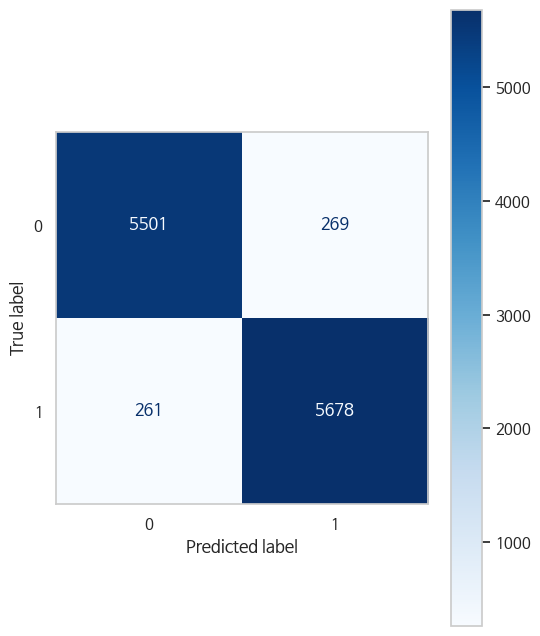

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.grid(False)
plt.show()

- 속성 중요도 확인

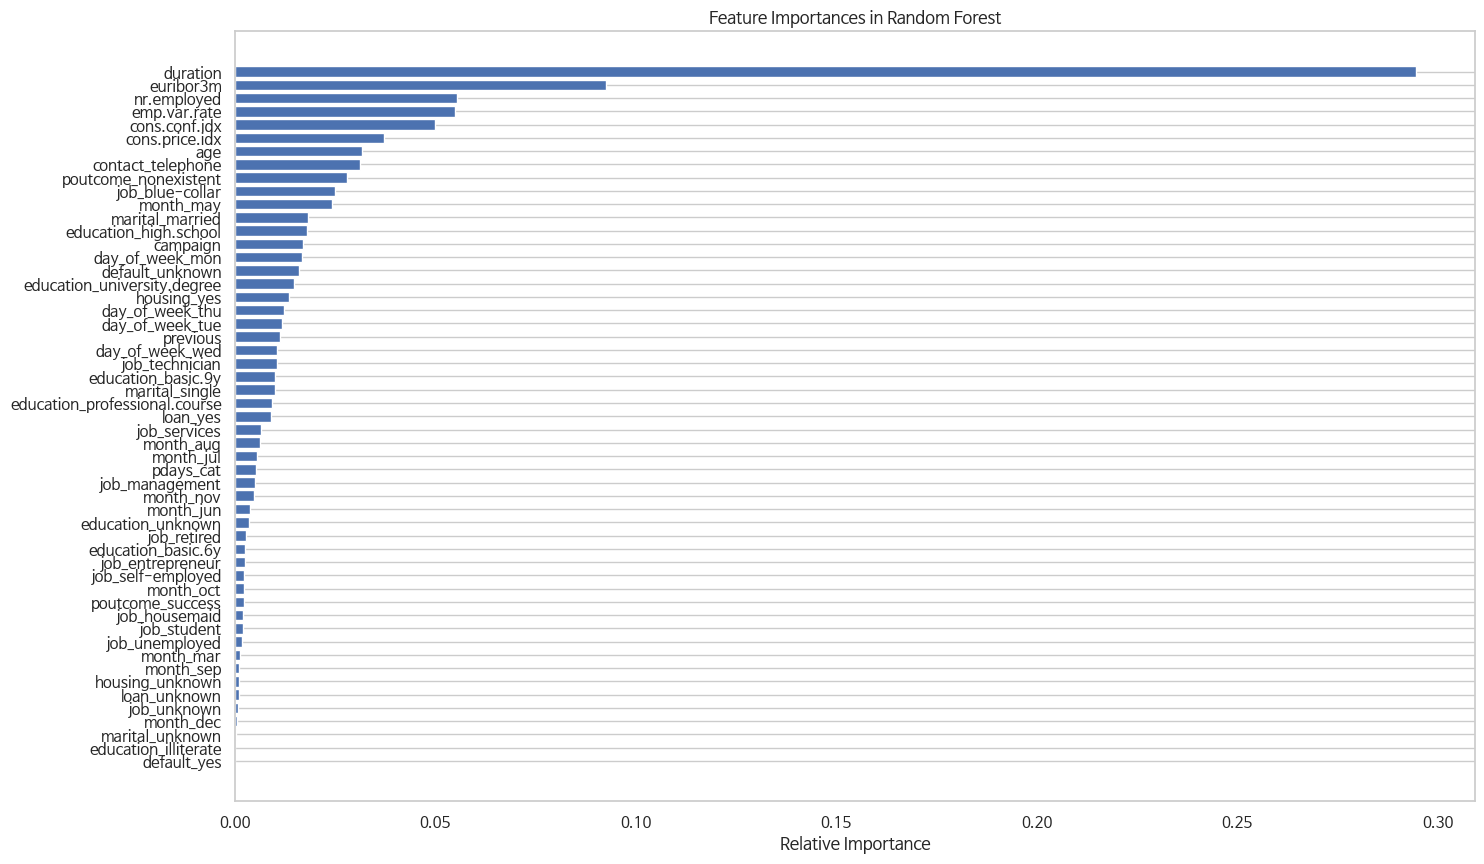

In [54]:
# 속성 중요도 추출
importances = grid_search.best_estimator_.feature_importances_

# 속성 이름 정의
feature_names = X_train.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - 랜덤 포레스트")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

> 결과 해석
- `duration`이 정기 예금 가입 여부에 가장 큰 영향을 준다.
- 예측에 가장 중요하게 활용된 Feature Top10 = `duration`, `euribor3m`, `nr.employed`, `emp.var.rate`, `cons.conf.idx`, `cons.price.idx`, `age`, `contact_telephone`, `poutcome_nonexistent`, `job_blue-collar`

#### ㄴ XGboost

- 모델 개발

In [56]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# XGBoost 모델 및 하이퍼파라미터 그리드 정의
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost 모델 설정
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# GridSearchCV 실행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

#테스트 데이터에 대한 예측
y_test_pred = best_model.predict(X_test)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


- 결과 출력

In [57]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}


In [58]:
# 모델 평가
## 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='binary')  # 'binary'는 이진 분류의 경우
recall = recall_score(y_test, y_test_pred, average='binary')
f1 = f1_score(y_test, y_test_pred, average='binary')
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])  # 예측 확률을 기반으로 AUC 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

## 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9549
Precision: 0.9562
Recall: 0.9549
F1 Score: 0.9555
ROC AUC: 0.9933
Confusion Matrix:
[[5510  260]
 [ 268 5671]]


- 분류 리포트 확인

In [59]:
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5770
           1       0.96      0.95      0.96      5939

    accuracy                           0.95     11709
   macro avg       0.95      0.95      0.95     11709
weighted avg       0.95      0.95      0.95     11709



- Confusion Matrix 시각화

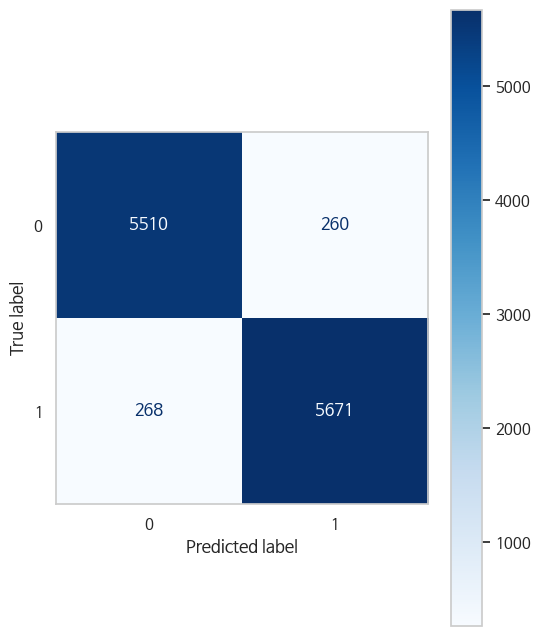

In [61]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.grid(False)
plt.show()

- 속성 중요도 확인

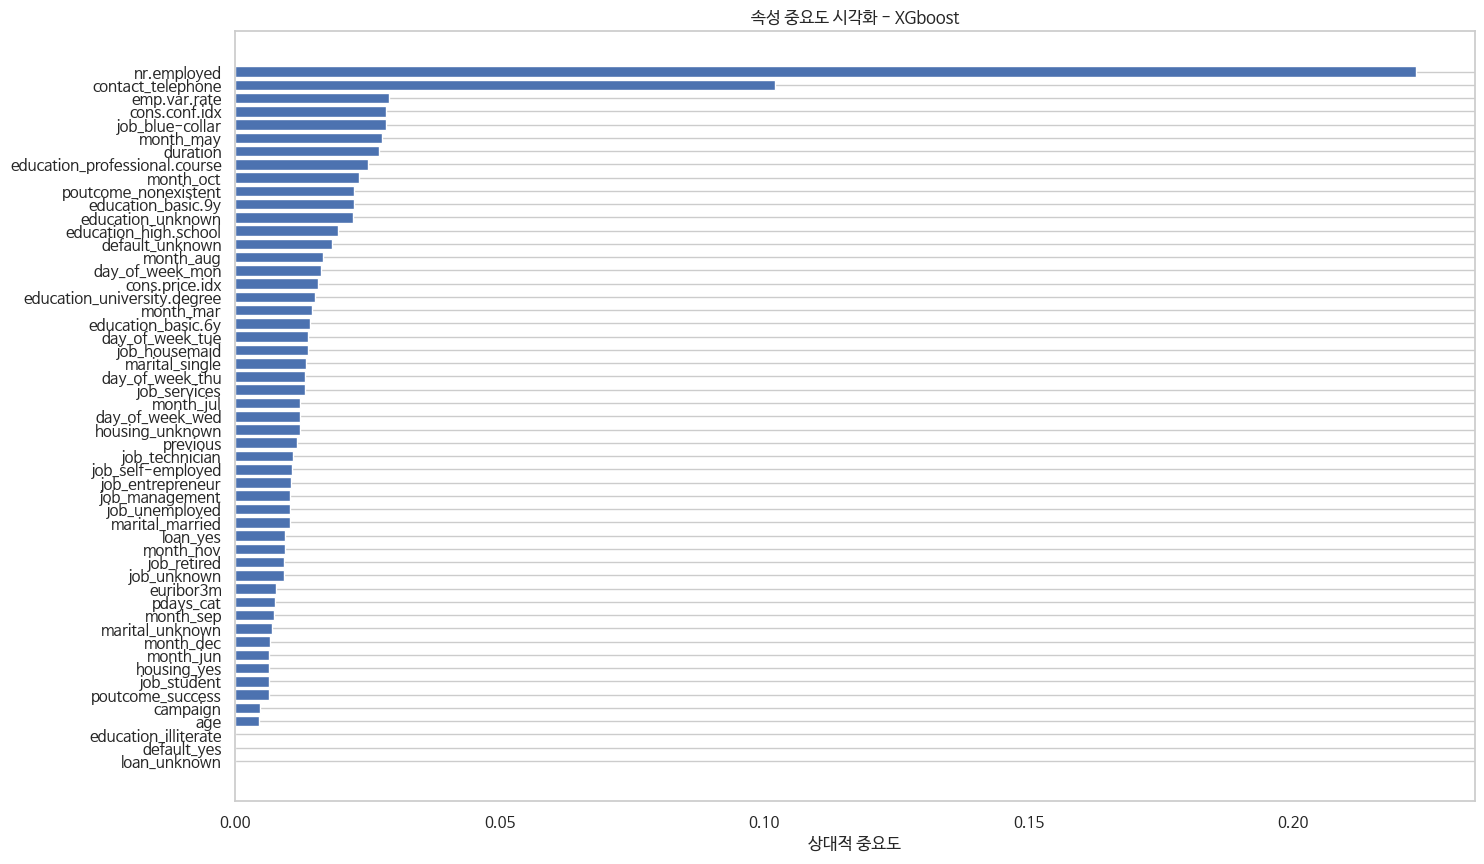

In [62]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_train.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - XGboost")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

> 결과 해석
- `nr.employed`이 정기 예금 가입 여부에 가장 큰 영향을 준다.
- 예측에 가장 중요하게 활용된 Feature Top10 = `nr.employed`, `contact_telephone`, `emp.var.rate`, `cons.conf.idx`, `job_blue-collar`, `month_may`, `duration`, `education_professional.course`, `month_oct`, `pcoutcome_nonexistent`

#### ㄴ Lightgbm

- 모델 개발

In [73]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [20, 31, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# LightGBM 모델 설정
lgb_model = lgb.LGBMClassifier(random_state=42)

# GridSearchCV 실행
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

#테스트 데이터에 대한 예측
y_test_pred = best_model.predict(X_test)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[LightGBM] [Info] Number of positive: 23333, number of negative: 23502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 46835, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498196 -> initscore=-0.007217
[LightGBM] [Info] Start training from score -0.007217


- 결과 출력

In [74]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31, 'subsample': 0.6}


In [75]:
# 모델 평가
## 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='binary')  # 'binary'는 이진 분류의 경우
recall = recall_score(y_test, y_test_pred, average='binary')
f1 = f1_score(y_test, y_test_pred, average='binary')
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])  # 예측 확률을 기반으로 AUC 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

## 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9559
Precision: 0.9586
Recall: 0.9544
F1 Score: 0.9565
ROC AUC: 0.9934
Confusion Matrix:
[[5525  245]
 [ 271 5668]]


- 분류 리포트 확인

In [76]:
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      5770
           1       0.96      0.95      0.96      5939

    accuracy                           0.96     11709
   macro avg       0.96      0.96      0.96     11709
weighted avg       0.96      0.96      0.96     11709



- Confusion Matrix 시각화

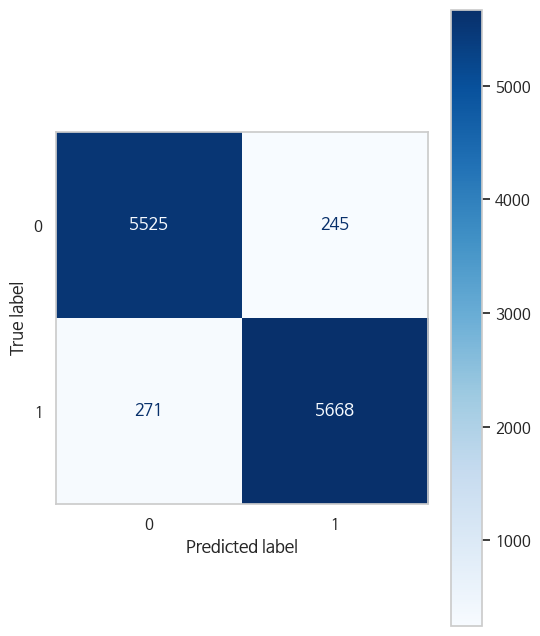

In [77]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.grid(False)
plt.show()

- 속성 중요도 확인

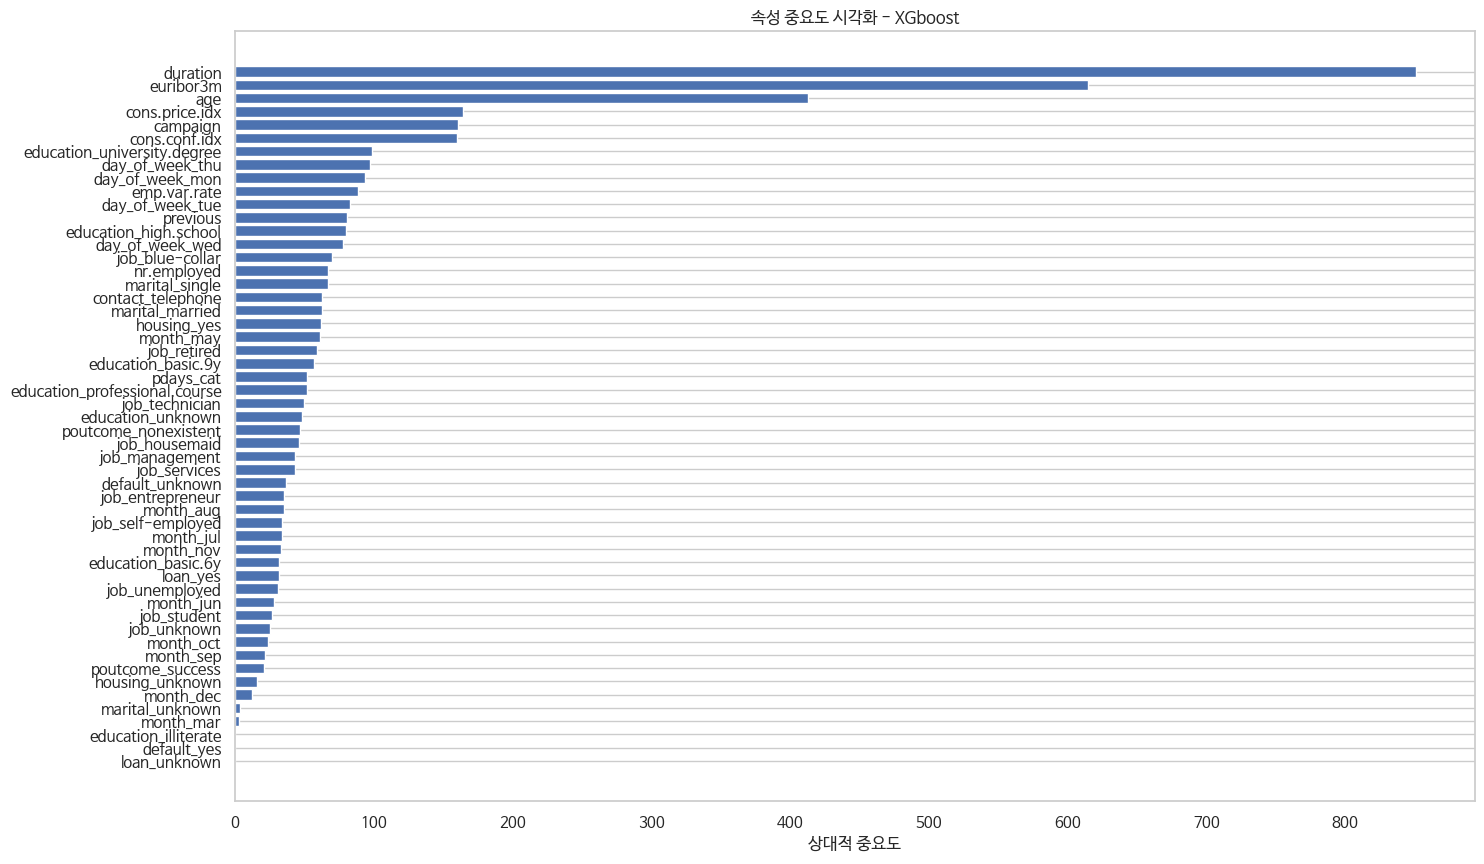

In [78]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_train.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - XGboost")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

> ##### **속성 선택**
- 각 모델의 속성 중요도 결과를 참고하여 클러스터링 수행할 속성 선별
- 각 모델 TOP10 교집합으로 속성 선별
  - 각 모델 성능에 따라 가중치를 두고 진행하려 했으나, 모델의 성능이 거의 비슷함
- 이후 선택된 속서으로 클러스터링으로 고객 세그멘테이션 후 세그먼트별 맞춤 마케팅 전략 기획

In [124]:
# 각 모델의 중요도 TOP10 속성
random_forest_features = {'duration', 'euribor3m', 'nr.employed', 'emp.var.rate', 'cons.conf.idx', 'cons.price.idx','age', 'contact_telephone', 'poutcome_nonexistent', 'job_blue-collar'}
xgboost_features = {'nr.employed', 'contact_telephone', 'emp.var.rate', 'cons.conf.idx', 'job_blue-collar', 'month_may', 'duration', 'education_professional.course', 'month_oct', 'pcoutcome_nonexistent'}
lightgbm_features = {'duration', 'euribor3m', 'age', 'cons.price.idx', 'campaign', 'cons.conf.idx', 'education_university.degree', 'day_of_week_thu', 'day_of_week_mon', 'emp.var.rate'}

# 공통적으로 중요한 Feature
common_features_3 = random_forest_features & xgboost_features & lightgbm_features
print("세 모델 공통적으로 중요한 Feature:", common_features_3)

common_features_2 = (random_forest_features & xgboost_features) | (lightgbm_features & xgboost_features) | (random_forest_features & lightgbm_features)
print("두 모델 공통적으로 중요한 Feature:", common_features_2)

세 모델 공통적으로 중요한 Feature: {'duration', 'emp.var.rate', 'cons.conf.idx'}
두 모델 공통적으로 중요한 Feature: {'cons.conf.idx', 'nr.employed', 'contact_telephone', 'cons.price.idx', 'age', 'job_blue-collar', 'duration', 'emp.var.rate', 'euribor3m'}


- 두 모델 공통적으로 중요한 속성 중에 가장 중요도가 높은 속성 2개를 추출하기 위해 점수 시스템 도입
  - 각 모델에서 중요도 순대로 10~1점 스코어링
  - 모델간 성능이 비슷하므로 가중치를 두지 않음
  - 각 모델의 해당 특성 점수의 총합으로 TOP2 선별

In [125]:
# 두 모델에서 포함된 특성 중 세 모델에서 전부 포함된 특성은 제외하여 리스트 생성
tmp = ['nr.employed', 'contact_telephone', 'cons.price.idx', 'age', 'job_blue-collar', 'euribor3m']

# scoring 시스템 개발
for feature in tmp:
    # get() 메서드를 사용하여 각 딕셔너리에서 feature가 없으면 기본값 0을 반환
    rf_score = random_forest_features_score.get(feature, 0)
    xgb_score = xgboost_features_score.get(feature, 0)
    lgb_score = lightgbm_features_score.get(feature, 0)

    # 세 가지 점수 합산 후 출력
    print(f'{feature} 점수 : {rf_score + xgb_score + lgb_score}')

nr.employed 점수 : 18
contact_telephone 점수 : 12
cons.price.idx 점수 : 12
age 점수 : 12
job_blue-collar 점수 : 7
euribor3m 점수 : 18


> 결론 1) 5가지 최종 속성 선택

- 세 모델 공통적으로 중요한 속성은 3개로 비교적 적으므로,2개를 더 추가하여 5개로 클러스터링을 진행하기로 한다.
- 두가지 모델에서 공통적으로 중요한 속성을 도출한 후, 각 모델에서 더 높은 순위를 기록한 속성 TOP2를 추가
- 최종 속성 : `duration`, `emp.var.rate`, `cons.conf.idx`, `nr.employed`, `euribor3m`

> 결론2) 최종 속성으로 도출된 5개 중 4개가 경제 관련 지표

- 경제 지표는 우리가 통제할 수 없는 지표이고, 해당 특성을 기준으로 클러스터링을 수행해서 고객을 군집화 하면, 경제 상황에 따른 전략 밖에 기획할 수 없으므로 실효성있는 인사이트 도출에 무리가 있다.
- 따라서, 경제 지표를 기준으로 경제 상황 좋은(A), 보통(B), 나쁨(C) 그룹으로 나누어 경제 상황이 동일한 그룹 내에서 클러스터링을 수행하기로 한다.
- 경제 지표를 제외하고 각 모델 속성 중요도를 고려한 특성 선별
  - `duration`, `age`, `contact_telephone`, `job_blue-collar`

In [222]:
# 데이터 누수 방지위한 데이터 프레임 복제
economic_df = encoded_df.copy()

# 사용할 경제 지표
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# KMeans를 사용하여 3개의 군집으로 분류
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
economic_df['economic_circumstance'] = kmeans.fit_predict(economic_df[economic_features])

# 표준화, 원핫 인코딩 전 데이터 프레임에도 라벨링
## 데이터 누수 방지위한 데이터 프레임 복제
tmp_result_df = outlier_processed_df.copy()
tmp_result_df['economic_circumstance'] = kmeans.fit_predict(tmp_result_df[economic_features])

# 결과 확인
economic_df[['economic_circumstance'] + economic_features].head()

,economic_circumstance,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1,1.1,93.994,-36.4,4.857,5191.0
1,1,1.1,93.994,-36.4,4.857,5191.0
2,1,1.1,93.994,-36.4,4.857,5191.0
3,1,1.1,93.994,-36.4,4.857,5191.0
4,1,1.1,93.994,-36.4,4.857,5191.0


In [224]:
tmp_result_df['economic_circumstance'].value_counts()

,count
economic_circumstance,
1,27682
0,10194
2,3300


In [196]:
economic_df.groupby('economic_circumstance').mean()[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
economic_circumstance,,,,,
0,-1.979341,92.880761,-44.806602,1.292344,5095.366451
1,1.115786,93.842690,-39.462098,4.817123,5213.382248
2,-2.223212,93.483039,-35.938667,0.784435,4999.640848


> 경제 상황에 따른 그룹 구분

- 그룹 0: emp.var.rate가 -1.98로 비교적 낮고, nr.employed도 중간 수준 > `보통` 그룹
- 그룹 1: emp.var.rate가 가장 높고, nr.employed도 가장 많으며, euribor3m도 가장 높음 > `좋음` 그룹
- 그룹 2: emp.var.rate가 가장 낮고, nr.employed도 가장 적음 > `나쁨` 그룹

---

## 클러스터링 분석 및 전략 제안

#### ㄴ 1) 경제 상황 보통 그룹(0)

- 경제 상황 보통 그룹 선별

In [225]:
# 그룹 0
mid_df = economic_df[economic_df['economic_circumstance'] == 0]
mid_df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_cat,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes,economic_circumstance
27690,26,712,4,0,-1.8,92.843,-50.0,1.811,5099.1,0,...,0,0,1,0,0,0,1,0,1,0
27691,38,111,2,0,-1.8,92.843,-50.0,1.811,5099.1,0,...,0,0,1,0,0,0,1,0,1,0
27692,26,42,4,0,-1.8,92.843,-50.0,1.811,5099.1,0,...,0,0,1,0,0,0,1,0,0,0
27693,26,169,4,0,-1.8,92.843,-50.0,1.811,5099.1,0,...,0,0,1,0,0,0,1,0,0,0
27694,30,213,7,0,-1.8,92.843,-50.0,1.811,5099.1,0,...,0,0,1,0,0,0,1,0,0,0


In [226]:
# clustering 위한 데이터 프레임 생성
cluster_df = mid_df[['duration', 'age', 'contact_telephone', 'job_blue-collar']]
cluster_df.head(3)

,duration,age,contact_telephone,job_blue-collar
27690,712,26,0,0
27691,111,38,0,0
27692,42,26,0,0


- 표준화

In [227]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
scaled_df = cluster_df.copy()

# 표준화 모델 생성 및 학습
scaler = StandardScaler()
scaled_df[['duration', 'age']] = scaler.fit_transform(scaled_df[['duration', 'age']])
scaled_df.head()

,duration,age,contact_telephone,job_blue-collar
27690,1.797592,-1.164093,0,0
27691,-0.601686,-0.043891,0,0
27692,-0.877144,-1.164093,0,0
27693,-0.370142,-1.164093,1,0
27694,-0.194488,-0.790693,1,0


In [228]:
# 표준화 확인
scaled_df.describe()

,duration,age,contact_telephone,job_blue-collar
count,1.019400e+04,1.019400e+04,10194.000000,10194.000000
mean,-1.254637e-17,-1.951658e-16,0.077006,0.252403
std,1.000049e+00,1.000049e+00,0.266614,0.434413
min,-1.044814e+00,-2.004245e+00,0.000000,0.000000
25%,-6.296311e-01,-6.973425e-01,0.000000,0.000000
50%,-2.863068e-01,-2.305916e-01,0.000000,0.000000
75%,2.646089e-01,5.162098e-01,0.000000,1.000000
max,1.296361e+01,5.277069e+00,1.000000,1.000000


- elbow-method : 최적 클러스터 수 도출

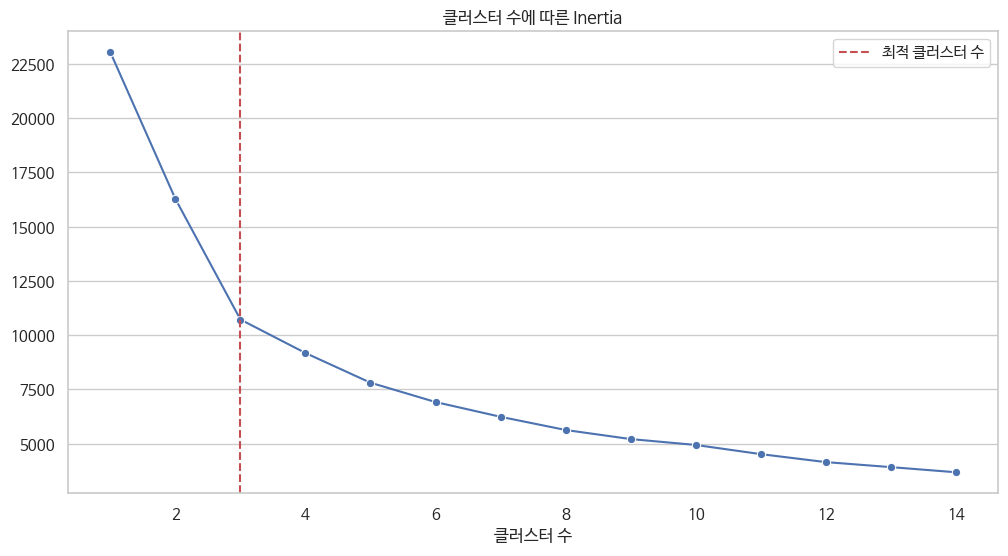

In [229]:
from sklearn.cluster import KMeans

# elbow-method 시각화
inertias = []
for k in range(1,15):
    model = KMeans(n_clusters=k,init='k-means++')
    model.fit(scaled_df)
    inertias.append(model.inertia_)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(12,6)},font='NanumBarunGothic',font_scale=1)
sns.lineplot(x=range(1,15), y=inertias, marker='o')
plt.axvline(x=3,linestyle='--',color='r',label='최적 클러스터 수')
plt.title('클러스터 수에 따른 Inertia')
plt.xlabel('클러스터 수')
plt.grid(axis='x')
plt.legend()
plt.show()

- 클러스터링 수행

In [230]:
# 클러스터 모델 생성 및 학습
model = KMeans(n_clusters=3, random_state=123, init='k-means++')
model.fit(scaled_df)

# 클러스터 라벨링
scaled_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석

# 실루엣 계수 확인
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(scaled_df, scaled_df['label'])
print("실루엣 계수:", silhouette)

실루엣 계수: 0.46936620820072095


> 실루엣 계수가 약 `0.47`으로 평균적인 성능을 보이지만, 이것은 가장 주요한 특성인 경제 지표를 배제한 클러스티링 작업 수행으로 인한 현상이므로 해당 모델로 클러스터링 수행 및 해석 진행

In [234]:
# 표준화 전 데이터 프레임 복제
result_df = mid_df.copy()

# 클러스터 라벨링
result_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석
result_df = result_df.groupby('label').mean()

> ##### 결과 해석

1. 마케팅 캠페인 데이터, 회원정보 데이터에서 유의미한 특성만 추출
  - 단, 같은 범주에서는 하나의 특성만 추출한다.
  - (Ex. `marital_single`, `marital_married` 두 가지 툭성 모두 유의미한 차이를 보인다면, 이중 하나만 선택)

2. 추출한 특성 기준으로 클러스터링 해석 및 마케팅 인사이트 도출

In [238]:
# 클러스터별 마케팅 캠페인 데이터 비교
result_df[['contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y_yes']].T

label,0,1,2
contact_telephone,0.048713,0.078346,0.085297
month_aug,0.046875,0.060936,0.122334
month_dec,0.000000,0.000000,0.000000
month_jul,0.016544,0.013835,0.026188
month_jun,0.048713,0.071351,0.075945
month_mar,0.009191,0.031711,0.025440
month_may,0.581801,0.608425,0.466143
month_nov,0.000000,0.000000,0.000000
month_oct,0.000000,0.000000,0.000000
month_sep,0.000000,0.000000,0.000000


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `poutcome_success`, `month_aug`, `contact_telephone`


In [239]:
# 클러스터별 회원정보 데이터 비교
result_df[['age', 'duration', 'campaign', 'previous',
       'pdays_cat', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes']].T

label,0,1,2
age,37.246324,32.887766,52.403292
duration,818.497243,189.736670,208.323232
campaign,2.012868,2.221670,2.108118
previous,0.328125,0.328463,0.351665
pdays_cat,0.099265,0.048189,0.072578
job_blue-collar,0.271140,0.262397,0.220726
job_entrepreneur,0.034926,0.024405,0.053872
job_housemaid,0.007353,0.008550,0.028807
job_management,0.056066,0.055340,0.098017
job_retired,0.017463,0.002021,0.146652


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `age`, `duration`, `job_retired`, `marital_single`



> ##### 최종 결과 및 그룹별 마케팅 인사이트

- 클러스터별 최종 선별 특성

In [242]:
# 클러스터별 최종 선별 특성
result_df[['poutcome_success','month_aug', 'contact_telephone', 'age', 'duration', 'job_retired', 'marital_single', 'y_yes']]

,poutcome_success,month_aug,contact_telephone,age,duration,job_retired,marital_single,y_yes
label,,,,,,,,
0,0.064338,0.046875,0.048713,37.246324,818.497243,0.017463,0.364890,0.508272
1,0.034976,0.060936,0.078346,32.887766,189.736670,0.002021,0.444894,0.113166
2,0.052001,0.122334,0.085297,52.403292,208.323232,0.146652,0.101758,0.151141


- 클러스터별 마케팅 전략 제안

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|----------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (경제 활동의 주축) | - 예금 가입률 50.8% (가장 높음) <br> - 장시간 상담 가능 (818.5초) <br> - 기존 캠페인 성공률 가장 높음 (6.43%) <br> - 30대 중반 연령층 (37.25세) <br> - 미혼 비율 36.49% | - **AM의 개별 관리 전략**: 상담에 충분히 시간을 투자하는 특성이 있으므로, 담당 Account Manager이 집중 관리하며 팔로우업 <br> - **리타겟팅(리마케팅)**: 과거 가입 고객에게 이메일 및 카카오톡 활용하여 맞춤 혜택 홍보 <br> - **디지털 마케팅 활용**: 이메일/앱 푸시 알림을 통한 프로모션 진행 | - 고이율 정기 예금 <br> - 자동 재예치 옵션 제공 |
| **Cluster 1** (사회 초년생) | - 예금 가입률 11.3% (가장 낮음) <br> - 평균 연령 32.89세 (젊은 층) <br> - 전화 상담 시간 짧음 (189.74초) <br> - 미혼 비율 가장 높음 (44.49%) <br> - 전화 연락 비율 7.83%로 가장 높음 | - **단기 혜택 강조**: 예금 이자율 인상, 가입 시 캐시백 프로모션 <br> - **소액 상품 추천**: 초기 부담이 적은 소액 정기 예금 상품 홍보 <br> - **디지털 마케팅 집중**: 전화보다 이메일, SNS, 앱 푸시 활용 | - 단기(6개월~1년) 소액 정기 예금 <br> - 자동이체 시 보너스 금리 적용 |
| **Cluster 2** (중장년층의 은퇴 대비자) | - 예금 가입률 15.1% (중간 수준) <br> - 평균 연령 52.4세 (가장 높음) <br> - 은퇴자 비율 가장 높음 (14.67%) <br> - 소비자 신뢰도 중간 수준 <br> - 통화 시간 208.32초 (중간) | - **장기 예금 상품 강조**: 안정적인 금융 상품 선호, 노후준비 소구점 활용 <br> - **세금 혜택 및 연금 연계 상품 홍보**: 장기 가입 유도 <br> - **오프라인 상담 유도**: 은행 방문 상담 혜택 제공  | - 장기(3년 이상) 고이율 정기 예금 <br> - 세금 우대 예금 <br> - 연금 연계 예금 상품 <br> - 증여 우대형 상품(자녀,손자손녀에게 양도할 경우 우대금리)|

#### ㄴ 2) 경제 상황 좋음 그룹(1)

- 경제 상황 좋음 그룹 선별

In [243]:
# 그룹 1
best_df = economic_df[economic_df['economic_circumstance'] == 1]
best_df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_cat,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes,economic_circumstance
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,1,0,0,0,1,0,0,1
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,1,0,0,0,1,0,0,1
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,1,0,0,0,1,0,0,1
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,1,0,0,0,1,0,0,1
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,1,0,0,0,1,0,0,1


In [244]:
# clustering 위한 데이터 프레임 생성
cluster_df = best_df[['duration', 'age', 'contact_telephone', 'job_blue-collar']]
cluster_df.head(3)

,duration,age,contact_telephone,job_blue-collar
0,261,56,1,0
1,149,57,1,0
2,226,37,1,0


- 표준화

In [245]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
scaled_df = cluster_df.copy()

# 표준화 모델 생성 및 학습
scaler = StandardScaler()
scaled_df[['duration', 'age']] = scaler.fit_transform(scaled_df[['duration', 'age']])
scaled_df.head()

,duration,age,contact_telephone,job_blue-collar
0,0.032937,1.720164,1,0
1,-0.394623,1.829002,1,0
2,-0.100675,-0.347766,1,0
3,-0.386988,-0.021251,1,0
4,0.208542,1.720164,1,0


In [246]:
# 표준화 확인
scaled_df.describe()

,duration,age,contact_telephone,job_blue-collar
count,2.768200e+04,2.768200e+04,27682.000000,27682.000000
mean,1.232066e-17,-8.881142e-17,0.495340,0.233762
std,1.000018e+00,1.000018e+00,0.499987,0.423230
min,-9.634307e-01,-2.415696e+00,0.000000,0.000000
25%,-5.893155e-01,-7.831200e-01,0.000000,0.000000
50%,-3.106379e-01,-1.300895e-01,0.000000,0.000000
75%,2.047248e-01,7.406179e-01,1.000000,0.000000
max,1.781104e+01,2.264356e+00,1.000000,1.000000


- elbow-method : 최적 클러스터 수 도출

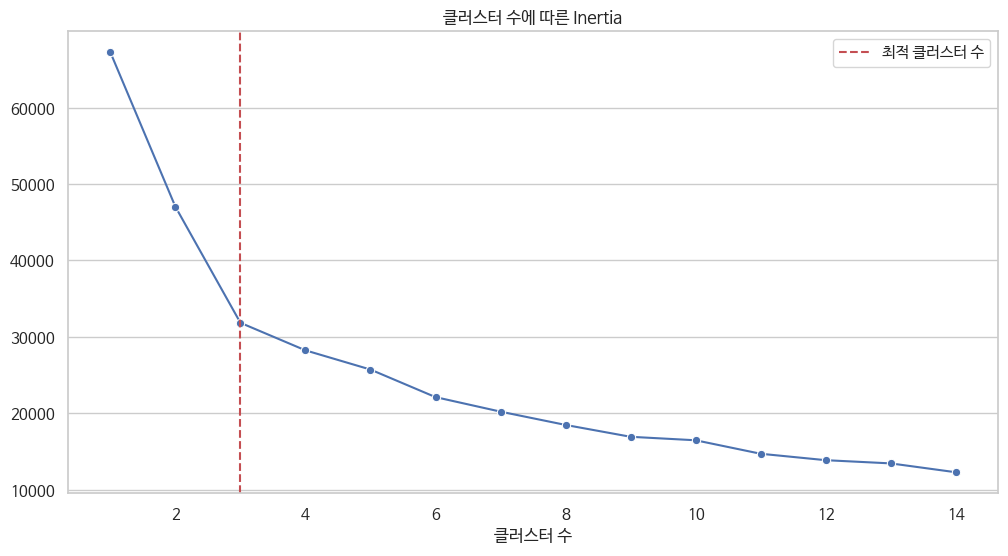

In [247]:
from sklearn.cluster import KMeans

# elbow-method 시각화
inertias = []
for k in range(1,15):
    model = KMeans(n_clusters=k,init='k-means++')
    model.fit(scaled_df)
    inertias.append(model.inertia_)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(12,6)},font='NanumBarunGothic',font_scale=1)
sns.lineplot(x=range(1,15), y=inertias, marker='o')
plt.axvline(x=3,linestyle='--',color='r',label='최적 클러스터 수')
plt.title('클러스터 수에 따른 Inertia')
plt.xlabel('클러스터 수')
plt.grid(axis='x')
plt.legend()
plt.show()

- 클러스터링 수행

In [248]:
# 클러스터 모델 생성 및 학습
model = KMeans(n_clusters=3, random_state=123, init='k-means++')
model.fit(scaled_df)

# 클러스터 라벨링
scaled_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석

# 실루엣 계수 확인
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(scaled_df, scaled_df['label'])
print("실루엣 계수:", silhouette)

실루엣 계수: 0.4330546984298901


> 실루엣 계수가 약 `0.43`으로 평균적인 성능을 보이지만, 이것은 가장 주요한 특성인 경제 지표를 배제한 클러스티링 작업 수행으로 인한 현상이므로 해당 모델로 클러스터링 수행 및 해석 진행

In [249]:
# 표준화 전 데이터 프레임 복제
result_df = best_df.copy()

# 클러스터 라벨링
result_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석
result_df = result_df.groupby('label').mean()

> ##### 결과 해석

1. 마케팅 캠페인 데이터, 회원정보 데이터에서 유의미한 특성만 추출
  - 단, 같은 범주에서는 하나의 특성만 추출한다.
  - (Ex. `marital_single`, `marital_married` 두 가지 툭성 모두 유의미한 차이를 보인다면, 이중 하나만 선택)

2. 추출한 특성 기준으로 클러스터링 해석 및 마케팅 인사이트 도출

In [250]:
# 클러스터별 마케팅 캠페인 데이터 비교
result_df[['contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y_yes']].T

label,0,1,2
contact_telephone,0.490546,0.504706,0.459869
month_aug,0.207884,0.177738,0.150696
month_dec,0.000378,0.000409,0.000000
month_jul,0.220079,0.247852,0.294431
month_jun,0.158064,0.159937,0.146192
month_mar,0.000000,0.000000,0.000000
month_may,0.279259,0.282908,0.270270
month_nov,0.132256,0.128564,0.135545
month_oct,0.002080,0.002592,0.002867
month_sep,0.000000,0.000000,0.000000


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `poutcome_success`, `contact_telephone`


In [251]:
# 클러스터별 회원정보 데이터 비교
result_df[['age', 'duration', 'campaign', 'previous',
       'pdays_cat', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes']].T

label,0,1,2
age,49.644829,33.583413,38.960688
duration,192.349783,187.119970,904.149877
campaign,2.854226,2.783522,2.660524
previous,0.029022,0.025986,0.019656
pdays_cat,0.001324,0.001296,0.000819
job_blue-collar,0.238608,0.228482,0.244472
job_entrepreneur,0.043203,0.034238,0.043817
job_housemaid,0.041974,0.022030,0.023342
job_management,0.090565,0.059132,0.077805
job_retired,0.068444,0.001432,0.020475


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `age`, `duration`, `job_retired`, `marital_single`, `default_unknown`



> ##### 최종 결과 및 그룹별 마케팅 인사이트

- 클러스터별 최종 선별 특성

In [252]:
# 클러스터별 최종 선별 특성
result_df[['poutcome_success','contact_telephone', 'age', 'duration', 'job_retired', 'marital_single', 'y_yes', 'default_unknown']]

,poutcome_success,contact_telephone,age,duration,job_retired,marital_single,y_yes,default_unknown
label,,,,,,,,
0,0.001324,0.490546,49.644829,192.349783,0.068444,0.087067,0.014086,0.365286
1,0.001296,0.504706,33.583413,187.119970,0.001432,0.357523,0.012481,0.185855
2,0.000819,0.459869,38.960688,904.149877,0.020475,0.266175,0.412367,0.241196


- 클러스터별 마케팅 전략 제안

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|-------------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (중장년의 은퇴 준비자) | - 예금 가입률 36.5% (중간) <br> - 평균 연령 49.64세 (중장년층) <br> - 전화 연락 비율 49.05% (높음) <br> - 은퇴자 비율 6.84% (중간) <br> - 미혼 비율 8.71% (낮음) <br> - 통화 시간 192.35초 (짧음) | - **전화 상담 활용**: 전화 응답률이 높아 상담을 통해 즉각적인 혜택 제공 <br> - **안정성과 고수익성 강조**: 긍정적인 경제 상황을 반영한 고이율 상품 홍보 <br> - **은퇴 후 자산 관리 플랜 컨설팅 서비스 제공**: 은퇴를 대비하여 어떻게 자산을 관리해야하는지 전문 컨설팅 제공 | - 중기(1~3년) 정기 예금 <br> - 고이율 상품 <br> - 투자형 예금 상품 |
| **Cluster 1** (재테크 입문자) | - 예금 가입률 18.6% (가장 낮음) <br> - 평균 연령 33.58세 (젊은 층) <br> - 전화 연락 비율 50.47% (가장 높음) <br> - 은퇴자 비율 0.14% (거의 없음) <br> - 미혼 비율 35.75% (높음) <br> - 통화 시간 187.12초 (가장 짧음) |  - **단기 고수익 혜택 제공**: 예금 이자율을 높이고, 가입 시 **즉시 보너스** 제공 <br> - **소액 정기예금 상품 홍보**: 낮은 금액으로 시작할 수 있는 상품 홍보 <br> - **디지털 마케팅 집중**: 젊은 층을 겨냥해 SNS, 앱, 이메일로 홍보 채널 선정 | - 단기(6개월~1년) 고수익 정기 예금 <br> - 자동이체 보너스 금리 <br> - 젊은 층 맞춤 소액 투자 상품 |
| **Cluster 2** (경제 활동의 주축) | - 예금 가입률 24.1% (중하) <br> - 평균 연령 38.96세 (중간) <br> - 전화 연락 비율 45.99% (다소 낮음) <br> - 은퇴자 비율 2.05% (중간) <br> - 미혼 비율 26.62% (중간) <br> - 통화 시간 904.15초 (가장 김) <br> - 연체 여부 불명 고객(default_unknown) 비율 41.24% (가장 높음) | - **긴 상담 활용**: 경제 성장과 수익 증대 가능성을 강조하며, 장기적인 투자 혜택 설명 <br> - **신용 정보 제공 및 관리**: 신용 관리와 함께 신뢰를 바탕으로 **장기 투자** 유도 <br> - **장기 성장 상품** 추천: **주식형 예금** 등 성장 가능성을 고려한 투자 상품 제안 | - 장기(3년 이상) 고수익 정기 예금 <br> - 주식형 예금 <br> - 신용 관리와 투자 교육 패키지 |

#### ㄴ 3) 경제 상황 나쁨 그룹(2)

- 경제 상황 나쁨 그룹 선별

In [253]:
# 그룹 2
worst_df = economic_df[economic_df['economic_circumstance'] == 2]
worst_df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_cat,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes,economic_circumstance
37887,53,81,5,0,-3.4,92.379,-29.8,0.819,5017.5,0,...,0,1,0,0,1,0,1,0,0,2
37888,32,69,2,0,-3.4,92.379,-29.8,0.819,5017.5,0,...,0,1,0,0,1,0,1,0,0,2
37889,52,97,5,0,-3.4,92.379,-29.8,0.819,5017.5,0,...,0,1,0,0,1,0,1,0,0,2
37890,39,265,2,1,-3.4,92.379,-29.8,0.819,5017.5,3,...,0,1,0,0,1,0,0,1,1,2
37891,32,157,2,0,-3.4,92.379,-29.8,0.819,5017.5,0,...,0,1,0,0,1,0,1,0,0,2


In [254]:
# clustering 위한 데이터 프레임 생성
cluster_df = worst_df[['duration', 'age', 'contact_telephone', 'job_blue-collar']]
cluster_df.head(3)

,duration,age,contact_telephone,job_blue-collar
37887,81,53,0,0
37888,69,32,0,0
37889,97,52,1,0


- 표준화

In [255]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
scaled_df = cluster_df.copy()

# 표준화 모델 생성 및 학습
scaler = StandardScaler()
scaled_df[['duration', 'age']] = scaler.fit_transform(scaled_df[['duration', 'age']])
scaled_df.head()

,duration,age,contact_telephone,job_blue-collar
37887,-0.833042,0.581629,0,0
37888,-0.879180,-0.688680,0,0
37889,-0.771525,0.521138,1,0
37890,-0.125597,-0.265243,0,0
37891,-0.540837,-0.688680,0,0


In [256]:
# 표준화 확인
scaled_df.describe()

,duration,age,contact_telephone,job_blue-collar
count,3.300000e+03,3.300000e+03,3300.000000,3300.000000
mean,-8.182007e-17,1.291896e-16,0.164848,0.063333
std,1.000152e+00,1.000152e+00,0.371100,0.243598
min,-1.140627e+00,-1.596043e+00,0.000000,0.000000
25%,-6.138879e-01,-8.096614e-01,0.000000,0.000000
50%,-2.640102e-01,-3.257343e-01,0.000000,0.000000
75%,2.742631e-01,7.026109e-01,0.000000,0.000000
max,1.340813e+01,3.303719e+00,1.000000,1.000000


- elbow-method : 최적 클러스터 수 도출

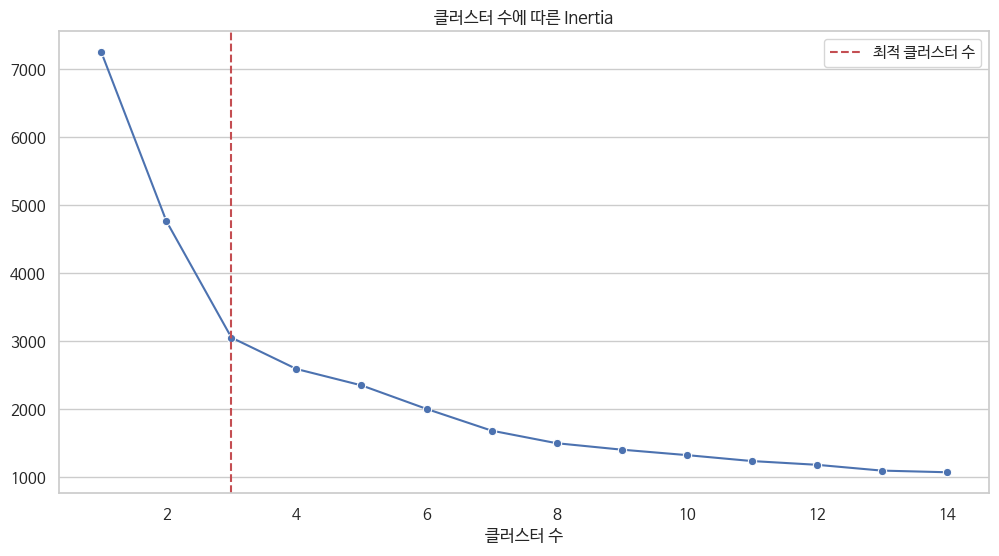

In [257]:
from sklearn.cluster import KMeans

# elbow-method 시각화
inertias = []
for k in range(1,15):
    model = KMeans(n_clusters=k,init='k-means++')
    model.fit(scaled_df)
    inertias.append(model.inertia_)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(12,6)},font='NanumBarunGothic',font_scale=1)
sns.lineplot(x=range(1,15), y=inertias, marker='o')
plt.axvline(x=3,linestyle='--',color='r',label='최적 클러스터 수')
plt.title('클러스터 수에 따른 Inertia')
plt.xlabel('클러스터 수')
plt.grid(axis='x')
plt.legend()
plt.show()

- 클러스터링 수행

In [258]:
# 클러스터 모델 생성 및 학습
model = KMeans(n_clusters=3, random_state=123, init='k-means++')
model.fit(scaled_df)

# 클러스터 라벨링
scaled_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석

# 실루엣 계수 확인
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(scaled_df, scaled_df['label'])
print("실루엣 계수:", silhouette)

실루엣 계수: 0.5091326674531726


> 실루엣 계수가 약 `0.43`으로 평균적인 성능을 보이지만, 이것은 가장 주요한 특성인 경제 지표를 배제한 클러스티링 작업 수행으로 인한 현상이므로 해당 모델로 클러스터링 수행 및 해석 진행

In [259]:
# 표준화 전 데이터 프레임 복제
result_df = worst_df.copy()

# 클러스터 라벨링
result_df['label'] = model.labels_ # 표준화 전 원본 데이터 테이블에 라벨 붙여서 해석
result_df = result_df.groupby('label').mean()

> ##### 결과 해석

1. 마케팅 캠페인 데이터, 회원정보 데이터에서 유의미한 특성만 추출
  - 단, 같은 범주에서는 하나의 특성만 추출한다.
  - (Ex. `marital_single`, `marital_married` 두 가지 툭성 모두 유의미한 차이를 보인다면, 이중 하나만 선택)

2. 추출한 특성 기준으로 클러스터링 해석 및 마케팅 인사이트 도출

In [260]:
# 클러스터별 마케팅 캠페인 데이터 비교
result_df[['contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y_yes']].T

label,0,1,2
contact_telephone,0.124060,0.191511,0.138158
month_aug,0.061090,0.077122,0.062500
month_dec,0.070489,0.038302,0.075658
month_jul,0.091165,0.094720,0.101974
month_jun,0.034774,0.085921,0.085526
month_mar,0.078947,0.086439,0.042763
month_may,0.064850,0.062629,0.072368
month_nov,0.148496,0.151139,0.115132
month_oct,0.222744,0.183230,0.194079
month_sep,0.163534,0.175466,0.187500


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `day_of_week_wed`, `contact_telephone`, `month_mar`


In [262]:
# 클러스터별 회원정보 데이터 비교
result_df[['age', 'duration', 'campaign', 'previous',
       'pdays_cat', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes']].T

label,0,1,2
age,63.209586,32.782609,41.378289
duration,255.812970,224.406315,909.743421
campaign,1.925752,1.800725,1.937500
previous,0.892857,0.915114,0.855263
pdays_cat,0.389098,0.410455,0.490132
job_blue-collar,0.050752,0.066253,0.088816
job_entrepreneur,0.013158,0.015528,0.023026
job_housemaid,0.062030,0.011905,0.023026
job_management,0.068609,0.068323,0.082237
job_retired,0.439850,0.001035,0.095395


> 클러스터 별 비교적 유의미한 차이를 보이는 특성 : `age`, `duration`, `job_retired`, `marital_married`, `education_university.degree`



> ##### 최종 결과 및 그룹별 마케팅 인사이트

- 클러스터별 최종 선별 특성

In [263]:
# 클러스터별 최종 선별 특성
result_df[['day_of_week_wed', 'contact_telephone', 'month_mar', 'age', 'duration', 'job_retired', 'marital_married', 'education_university.degree', 'y_yes']]

,day_of_week_wed,contact_telephone,month_mar,age,duration,job_retired,marital_married,education_university.degree,y_yes
label,,,,,,,,,
0,0.189850,0.124060,0.078947,63.209586,255.812970,0.439850,0.755639,0.239662,0.490602
1,0.172360,0.191511,0.086439,32.782609,224.406315,0.001035,0.390269,0.457557,0.450311
2,0.240132,0.138158,0.042763,41.378289,909.743421,0.095395,0.575658,0.424342,0.733553


- 클러스터별 마케팅 전략 제안

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|-------------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (고령의 노후 대비자) | - 예금 가입률 49.06% (중간) <br> - 평균 연령 63.21세 (고연령층) <br> - 전화 연락 비율 12.41% (낮음) <br> - 은퇴자 비율 43.99% (상당히 높음) <br> - 기혼 비율 75.56% (높음) <br> - 대학 교육 비율 23.97% (낮음)  | - **안정적인 투자 강조**: 경제 불확실성에 대비하여 안정적인 고정금리 상품 홍보 <br> - **연금 연계 상품 강화**: 장기적으로 안정적인 수익을 원하는 은퇴자를 겨냥한 연금 상품 추천 <br> - **디지털 채널 강화**: 은퇴자가 온라인 서비스를 활용하기 어려울 수 있으므로, 고객 맞춤형 지원 채널 제공 | - 고정금리 정기 예금 <br> - 연금 연계 상품 <br> - 재테크 지원 서비스 |
| **Cluster 1** (재테크 입문자) | - 예금 가입률 45.03% (중하) <br> - 평균 연령 32.78세 (젊은 층) <br> - 전화 연락 비율 19.15% (상당히 높음) <br> - 은퇴자 비율 0.1% (거의 없음) <br> - 기혼 비율 39.03% (중간) <br> - 대학 교육 비율 45.76% (상당히 높음) | - **저위험/고수익 상품 강조**: 금리가 낮은 상황에서, 최소한의 리스크로 수익을 얻을 수 있는 상품 제공 <br> - **소액 투자 상품**: 자금 여유가 적은 고객을 겨냥해 적은 금액으로 시작할 수 있는 상품 추천 <br> - **분산 투자 옵션 제공**: 예금 외에도 다양한 소액 투자 상품 제공 <br> - 원금이 보장되고, 예금자보호법에 보호받는 정기예금의 핵심 소구점인 **안정성** 강조하여 입문자에게 적합함을 강조 | - 소액 정기 예금 <br> - 금리 우대형 상품 <br> - 분산 투자 상품 |
| **Cluster 2** (경제 활동의 주축) | - 예금 가입률 73.36% (가장 높음) <br> - 평균 연령 41.38세 (중간 연령층) <br> - 전화 연락 비율 13.82% (낮음) <br> - 은퇴자 비율 9.54% (낮음) <br> - 기혼 비율 57.57% (중간) <br> - 대학 교육 비율 42.43% (중간) | - **금리 인하 대비 고정금리 상품 강조**: 경제 불황에 대비하여 고정금리 상품으로 장기적인 안전성 강조 <br> - **조기 해지 시 불이익 최소화**: 유연한 해지 옵션 제공, 유동성 문제 해결을 위한 상품 설계 <br> - **안정성과 보장성을 강조**: 원금 보장이 강한 상품 홍보 | - 고정금리 정기 예금 <br> - 원금 보장형 금융 상품 <br> - 보험 연계 상품 |

---

## 결론

###  분석 과정 요약

1. EDA를 통해서 데이터에 대한 이해도를 높였다.
  - 데이터 전처리 수행함
  - 상관관계 및 회귀분석 진행하여 각 Feature의 대략적인 영향력을 파악함
  - 종속변수의 비율 차이를 확인하여 오버 샘플링 판단함

2. 데이터에 맞는 Feature Engineering을 수행하였다.
  - pdays를 범주로 구분하는 파생변수 생성
  - 범주형 변수 One-Hot Encoding 진행
  - 종속변수 오버 샘플링을 실시

3. 여러가지 예측 모델을 활용하여 중요도가 높은 독립변수를 선별하였다.
  - Random Forest, XGboost, LightGBM 활용
  - 세 가지 모델 성능이 거의 비슷했으므로 각 모델 속성 중요도 TOP10의 교집합으로 변수 선별
  - 선별된 변수 5개 중 4개가 경제 상황에 관한 변수여서 마케팅 인사이트 도출에 한계 존재
  - 변수 중요도 scoring 시스템 개발하여 경제 상황 제외하여 최종 변수 선별

4. 최종 선별된 변수로 클러스터링 실시하여 고객군별 맞춤 전략을 제안하였다.
  - 경제 지표 5개를 활용한 Kmeans 클러스터링으로 경제 상황 기준 생성 후 그룹핑(보통, 좋음, 나쁨)
  - 예측 모델에서 최종 선별한 변수로 각 그룹별 클러스터링 실시하여 경제상황별 고객군별 맞춤 전략 제안


### 경제상황별 고객군별 마케팅 전략 제안

#### 1. 경제 상황 보통 그룹

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|----------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (경제 활동의 주축) | - 예금 가입률 50.8% (가장 높음) <br> - 장시간 상담 가능 (818.5초) <br> - 기존 캠페인 성공률 가장 높음 (6.43%) <br> - 30대 중반 연령층 (37.25세) <br> - 미혼 비율 36.49% | - **AM의 개별 관리 전략**: 상담에 충분히 시간을 투자하는 특성이 있으므로, 담당 Account Manager이 집중 관리하며 팔로우업 <br> - **리타겟팅(리마케팅)**: 과거 가입 고객에게 이메일 및 카카오톡 활용하여 맞춤 혜택 홍보 <br> - **디지털 마케팅 활용**: 이메일/앱 푸시 알림을 통한 프로모션 진행 | - 고이율 정기 예금 <br> - 자동 재예치 옵션 제공 |
| **Cluster 1** (사회 초년생) | - 예금 가입률 11.3% (가장 낮음) <br> - 평균 연령 32.89세 (젊은 층) <br> - 전화 상담 시간 짧음 (189.74초) <br> - 미혼 비율 가장 높음 (44.49%) <br> - 전화 연락 비율 7.83%로 가장 높음 | - **단기 혜택 강조**: 예금 이자율 인상, 가입 시 캐시백 프로모션 <br> - **소액 상품 추천**: 초기 부담이 적은 소액 정기 예금 상품 홍보 <br> - **디지털 마케팅 집중**: 전화보다 이메일, SNS, 앱 푸시 활용 | - 단기(6개월~1년) 소액 정기 예금 <br> - 자동이체 시 보너스 금리 적용 |
| **Cluster 2** (중장년층의 은퇴 대비자) | - 예금 가입률 15.1% (중간 수준) <br> - 평균 연령 52.4세 (가장 높음) <br> - 은퇴자 비율 가장 높음 (14.67%) <br> - 소비자 신뢰도 중간 수준 <br> - 통화 시간 208.32초 (중간) | - **장기 예금 상품 강조**: 안정적인 금융 상품 선호, 노후준비 소구점 활용 <br> - **세금 혜택 및 연금 연계 상품 홍보**: 장기 가입 유도 <br> - **오프라인 상담 유도**: 은행 방문 상담 혜택 제공  | - 장기(3년 이상) 고이율 정기 예금 <br> - 세금 우대 예금 <br> - 연금 연계 예금 상품 <br> - 증여 우대형 상품(자녀,손자손녀에게 양도할 경우 우대금리)|
<br>

#### 2. 경제 상황 좋음 그룹

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|-------------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (중장년의 은퇴 준비자) | - 예금 가입률 36.5% (중간) <br> - 평균 연령 49.64세 (중장년층) <br> - 전화 연락 비율 49.05% (높음) <br> - 은퇴자 비율 6.84% (중간) <br> - 미혼 비율 8.71% (낮음) <br> - 통화 시간 192.35초 (짧음) | - **전화 상담 활용**: 전화 응답률이 높아 상담을 통해 즉각적인 혜택 제공 <br> - **안정성과 고수익성 강조**: 긍정적인 경제 상황을 반영한 고이율 상품 홍보 <br> - **은퇴 후 자산 관리 플랜 컨설팅 서비스 제공**: 은퇴를 대비하여 어떻게 자산을 관리해야하는지 전문 컨설팅 제공 | - 중기(1~3년) 정기 예금 <br> - 고이율 상품 <br> - 투자형 예금 상품 |
| **Cluster 1** (재테크 입문자) | - 예금 가입률 18.6% (가장 낮음) <br> - 평균 연령 33.58세 (젊은 층) <br> - 전화 연락 비율 50.47% (가장 높음) <br> - 은퇴자 비율 0.14% (거의 없음) <br> - 미혼 비율 35.75% (높음) <br> - 통화 시간 187.12초 (가장 짧음) |  - **단기 고수익 혜택 제공**: 예금 이자율을 높이고, 가입 시 **즉시 보너스** 제공 <br> - **소액 정기예금 상품 홍보**: 낮은 금액으로 시작할 수 있는 상품 홍보 <br> - **디지털 마케팅 집중**: 젊은 층을 겨냥해 SNS, 앱, 이메일로 홍보 채널 선정 | - 단기(6개월~1년) 고수익 정기 예금 <br> - 자동이체 보너스 금리 <br> - 젊은 층 맞춤 소액 투자 상품 |
| **Cluster 2** (경제 활동의 주축) | - 예금 가입률 24.1% (중하) <br> - 평균 연령 38.96세 (중간) <br> - 전화 연락 비율 45.99% (다소 낮음) <br> - 은퇴자 비율 2.05% (중간) <br> - 미혼 비율 26.62% (중간) <br> - 통화 시간 904.15초 (가장 김) <br> - 연체 여부 불명 고객(default_unknown) 비율 41.24% (가장 높음) | - **긴 상담 활용**: 경제 성장과 수익 증대 가능성을 강조하며, 장기적인 투자 혜택 설명 <br> - **신용 정보 제공 및 관리**: 신용 관리와 함께 신뢰를 바탕으로 **장기 투자** 유도 <br> - **장기 성장 상품** 추천: **주식형 예금** 등 성장 가능성을 고려한 투자 상품 제안 | - 장기(3년 이상) 고수익 정기 예금 <br> - 주식형 예금 <br> - 신용 관리와 투자 교육 패키지 |

<br>

#### 3. 경제 상황 나쁨 그룹

| 클러스터 | 특성 | 마케팅 전략 | 추천 상품 |
|----------|-------------------------------------------------|--------------------------------------------------|------------------------------|
| **Cluster 0** (고령의 노후 대비자) | - 예금 가입률 49.06% (중간) <br> - 평균 연령 63.21세 (고연령층) <br> - 전화 연락 비율 12.41% (낮음) <br> - 은퇴자 비율 43.99% (상당히 높음) <br> - 기혼 비율 75.56% (높음) <br> - 대학 교육 비율 23.97% (낮음)  | - **안정적인 투자 강조**: 경제 불확실성에 대비하여 안정적인 고정금리 상품 홍보 <br> - **연금 연계 상품 강화**: 장기적으로 안정적인 수익을 원하는 은퇴자를 겨냥한 연금 상품 추천 <br> - **디지털 채널 강화**: 은퇴자가 온라인 서비스를 활용하기 어려울 수 있으므로, 고객 맞춤형 지원 채널 제공 | - 고정금리 정기 예금 <br> - 연금 연계 상품 <br> - 재테크 지원 서비스 |
| **Cluster 1** (재테크 입문자) | - 예금 가입률 45.03% (중하) <br> - 평균 연령 32.78세 (젊은 층) <br> - 전화 연락 비율 19.15% (상당히 높음) <br> - 은퇴자 비율 0.1% (거의 없음) <br> - 기혼 비율 39.03% (중간) <br> - 대학 교육 비율 45.76% (상당히 높음) | - **저위험/고수익 상품 강조**: 금리가 낮은 상황에서, 최소한의 리스크로 수익을 얻을 수 있는 상품 제공 <br> - **소액 투자 상품**: 자금 여유가 적은 고객을 겨냥해 적은 금액으로 시작할 수 있는 상품 추천 <br> - **분산 투자 옵션 제공**: 예금 외에도 다양한 소액 투자 상품 제공 <br> - 원금이 보장되고, 예금자보호법에 보호받는 정기예금의 핵심 소구점인 **안정성** 강조하여 입문자에게 적합함을 강조 | - 소액 정기 예금 <br> - 금리 우대형 상품 <br> - 분산 투자 상품 |
| **Cluster 2** (경제 활동의 주축) | - 예금 가입률 73.36% (가장 높음) <br> - 평균 연령 41.38세 (중간 연령층) <br> - 전화 연락 비율 13.82% (낮음) <br> - 은퇴자 비율 9.54% (낮음) <br> - 기혼 비율 57.57% (중간) <br> - 대학 교육 비율 42.43% (중간) | - **금리 인하 대비 고정금리 상품 강조**: 경제 불황에 대비하여 고정금리 상품으로 장기적인 안전성 강조 <br> - **조기 해지 시 불이익 최소화**: 유연한 해지 옵션 제공, 유동성 문제 해결을 위한 상품 설계 <br> - **안정성과 보장성을 강조**: 원금 보장이 강한 상품 홍보 | - 고정금리 정기 예금 <br> - 원금 보장형 금융 상품 <br> - 보험 연계 상품 |

<br>